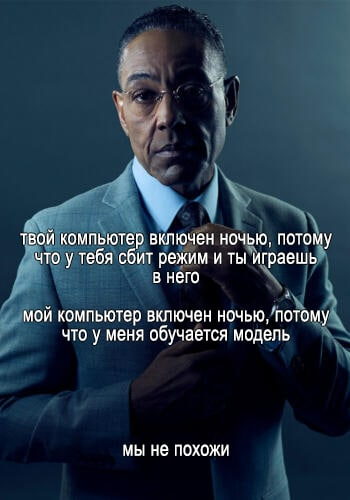

In [ ]:
!pip install geopy
!pip install hpsklearn
!pip install optuna
!pip install catboost
!pip install xgboost
!pip install yellowbrick

In [2]:
SEED = 666

In [413]:
import numpy as np
import pandas as pd
import string
import datetime
import re

from geopy.distance import geodesic
from hpsklearn import HyperoptEstimator
from sklearn.svm import LinearSVC
from hyperopt import tpe, STATUS_OK, Trials, hp, fmin, STATUS_OK, space_eval
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, average_precision_score
from sklearn.metrics import accuracy_score, f1_score, average_precision_score, roc_auc_score, classification_report, precision_score, recall_score
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate
import joblib


#импортируем библиотеки matplotlib и seaborn для построения графиков
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [7]:
train = pd.read_csv('https://drive.google.com/u/0/uc?id=1pVqiPMX7L7bqviBCE-13_uA6ZfBCzOgw&export=download', sep=';')
test = pd.read_csv('https://drive.google.com/uc?id=1YtjNEL0Yye6tkW26vpDbfQQv3dZvpSYr', sep=';')
submission = pd.read_csv('https://drive.google.com/uc?id=1MTZnySU5mGdppCp9zq8mg-Of1I_rSai8', sep=';')

In [9]:
mapper={
        'low':0,
        'medium':1,
        'high':2
       }
train['interest_level'] = train['interest_level'].apply(lambda x: mapper[x])

In [10]:
train.isna().sum()

bathrooms             0
bedrooms              0
building_id           0
created               0
description        1144
display_address     105
features              0
latitude              0
listing_id            0
longitude             0
manager_id            0
photos                0
price                 0
street_address        9
interest_level        0
dtype: int64

In [11]:
train.description = train.description.fillna('empty')
train = train.fillna(0)

In [12]:
train.isna().sum()

bathrooms          0
bedrooms           0
building_id        0
created            0
description        0
display_address    0
features           0
latitude           0
listing_id         0
longitude          0
manager_id         0
photos             0
price              0
street_address     0
interest_level     0
dtype: int64

# 1.Добавление новых фичей

1)Добавление фичей "количество атрибутов квартиры" и "количество фотографий"

In [13]:
train['num_features']=train['features'].str.replace('[\[\]\']', '').str.split(', ').apply(len)
train['num_photos']=train['photos'].str.replace('[\[\]\']', '').str.split(', ').apply(len)

C:\Users\user\AppData\Local\Temp\ipykernel_5440\2425897420.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train['num_features']=train['features'].str.replace('[\[\]\']', '').str.split(', ').apply(len)
C:\Users\user\AppData\Local\Temp\ipykernel_5440\2425897420.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train['num_photos']=train['photos'].str.replace('[\[\]\']', '').str.split(', ').apply(len)


2)ГИПОТЕЗА:популярость квартиры зависит от её удалённости до какого-либо объекта - добавление фичей "удалённость до какого-либо популярного объекта"

In [14]:
central_park = tuple([40.7736,-73.9727]) #Координаты центрального парка
time_square = tuple([40.7577,-73.9857])  #Координаты тайм-сквера
wall_street = tuple([40.7072,-74.0116])   #Координаты уолл-стрит

train['distance_central_park'] = train.latitude
train['distance_time_square'] = train.latitude
train['distance_wall_street'] = train.latitude

for i in range(train.shape[0]):
  train.distance_central_park.iloc[i] = geodesic((train.latitude.iloc[i],train.longitude.iloc[i]),central_park).miles

for i in range(train.shape[0]):
  train.distance_time_square.iloc[i] = geodesic((train.latitude.iloc[i],train.longitude.iloc[i]),time_square).miles

for i in range(train.shape[0]):
  train.distance_wall_street.iloc[i] = geodesic((train.latitude.iloc[i],train.longitude.iloc[i]),wall_street).miles

C:\Users\user\AppData\Local\Temp\ipykernel_5440\2074172399.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.distance_central_park.iloc[i] = geodesic((train.latitude.iloc[i],train.longitude.iloc[i]),central_park).miles
C:\Users\user\AppData\Local\Temp\ipykernel_5440\2074172399.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.distance_time_square.iloc[i] = geodesic((train.latitude.iloc[i],train.longitude.iloc[i]),time_square).miles
C:\Users\user\AppData\Local\Temp\ipykernel_5440\2074172399.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat

Также из лора гамбургероголовых(осуждаю) можно выдвинуть гипотезы, что популярность квартиры зависит от наличия в шаговой доступности: метро, школы, церкви, удалённость от какого-нибудь гетто, но я не знаю как добавить информацию об этом в датафрейм. С метро можно было бы также с помощью geopy вычислить расстояние до каждой станции и добавлять меньшее для каждого объявления, но станций 450+, а списком их координаты я не нашёл.

Посмотрим, есть ли чего интересного в атрибутах апартаментов

In [15]:
fich = set()

In [22]:
for i in range(train.shape[0]):
  for k in train['features'].str.replace('[\[\]\']', '').str.split(',').iloc[i]:
    fich.add(k)

C:\Users\user\AppData\Local\Temp\ipykernel_5440\1594133400.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  for k in train['features'].str.replace('[\[\]\']', '').str.split(',').iloc[i]:


In [23]:
fich

{'',
 ' Spotless Laundry',
 ' Gym',
 ' Southern Exposure',
 '** ELEGANT E50s!! * SPRAWLING SUNDRENCHED 2BR HOME * FRENCH DRS * BREAKFAST BAR * DISHWASHER * EAT-IN KITCHEN * WALK-IN CLOSETS! **',
 ' Balconies in both bedrooms',
 ' High-speed Internet',
 '"** SPRAWLING 2BR SUPER SHARE * MASSIVE WINDOWS GALORE * COOKS KITCHEN * 2 BLKS TO BEDFORD L STOP **"',
 ' convertible 2 bedroom',
 ' ROOFTOP',
 'Q',
 ' air conditioned laundry facility',
 ' On-site laundry',
 ' Resident Super in the building',
 ' HUGE Closets',
 ' Washer/Dryer in Bldg',
 ' Storage in basement',
 ' Semi-private Backyard',
 ' Laundry in Building!',
 ' Modern Finishes',
 ' private-balcony',
 ' Virtual Doorman',
 ' Low Fee',
 '** MASTERFUL BKLYN FIND! * SPRAWLING 3BR MEGA-SHARE * GOURMET KITCHEN * MR CLEAN APPROVED * 2 BLKS TO BEDFORD L **',
 ' Roof garden and lounge',
 ' Pre War',
 'a',
 'Prewar',
 ' "** EXTRA SWEET EAST VILLAGE! * MASSIVE 2BR HOME * ORNATE PREWAR DETAILS * EXPOSED BRICK * COOKS KITCHEN * PETS OK **"',
 '

In [187]:
for el in fich:
  if 'balcony' in el:
    print(el)

 private-balcony
balcony
 Common balcony
 balcony
 huge balcony
 "two en-suite balconys."
 Private balcony


3)Некоторые фичи из списка атрибутов квартиры

In [ ]:
# set([word.lower() for line in x for word in line.split()])

Информация о качалке

In [190]:
train['fitness_info'] = train['features'].str.replace('[\[\]\']', '').str.split(',').apply(lambda x: 1 if ('fitness' in set([word.lower().strip() for line in x for word in line.split()])
                                                                                                        or 'gym' in set([word.lower().strip() for line in x for word in line.split()])
                                                                                                        ) else 0)
train['fitness_info'].value_counts()

C:\Users\user\AppData\Local\Temp\ipykernel_5440\558777287.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train['fitness_info'] = train['features'].str.replace('[\[\]\']', '').str.split(',').apply(lambda x: 1 if ('fitness' in set([word.lower().strip() for line in x for word in line.split()])


0    28855
1    10626
Name: fitness_info, dtype: int64

Информация о балконе/террасе

In [191]:
train['terrace_balcony'] = train['features'].str.replace('[\[\]\']', '').str.split(',').apply(lambda x: 1 if ('balcony' in set([word.lower().strip() for line in x for word in line.split()])
                                                                                                        or 'terrace' in set([word.lower().strip() for line in x for word in line.split()])
                                                                                                        ) else 0)
train['terrace_balcony'].value_counts()

C:\Users\user\AppData\Local\Temp\ipykernel_5440\2820410889.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train['terrace_balcony'] = train['features'].str.replace('[\[\]\']', '').str.split(',').apply(lambda x: 1 if ('balcony' in set([word.lower().strip() for line in x for word in line.split()])


0    36216
1     3265
Name: terrace_balcony, dtype: int64

Информация о питомцах

In [184]:
train['pets_info'] = train['features'].str.replace('[\[\]\']', '').str.split(',').apply(lambda x: 1 if (' No Pets' in x
                                                                                                        or ' Pet friendly' in x
                                                                                                        or ' pets ok' in x 
                                                                                                        or 'pets' in x
                                                                                                        or ' Pets Allowed' in x
                                                                                                        or ' Dogs OK' in x
                                                                                                        or ' Pet friendly ( case by case )' in x
                                                                                                        or ' Pets Upon Approval' in x
                                                                                                        or ' All pets ok' in x
                                                                                                        or ' pets' in x
                                                                                                        or 'No pets' in x
                                                                                                        or ' Cats Allowed' in x
                                                                                                        or ' Dogs Allowed' in x
                                                                                                        or 'Dogs Allowed' in x
                                                                                                        or 'Cats Allowed' in x) else 0)
train['pets_info'].value_counts()

C:\Users\user\AppData\Local\Temp\ipykernel_5440\3883769307.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train['pets_info'] = train['features'].str.replace('[\[\]\']', '').str.split(',').apply(lambda x: 1 if (' No Pets' in x


0    20574
1    18907
Name: pets_info, dtype: int64

Информация о консьерже

In [194]:
train['doorman_info'] = train['features'].str.replace('[\[\]\']', '').str.split(',').apply(lambda x: 1 if ('doorman' in set([word.lower().strip() for line in x for word in line.split()])
                                                                                                        or 'oncierge' in set([word.lower().strip() for line in x for word in line.split()])
                                                                                                        #or 'Concierge' in x 
                                                                                                        #or 'Doorman' in x
                                                                                                        ) else 0)
train['doorman_info'].value_counts()

C:\Users\user\AppData\Local\Temp\ipykernel_5440\2002973187.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train['doorman_info'] = train['features'].str.replace('[\[\]\']', '').str.split(',').apply(lambda x: 1 if ('doorman' in set([word.lower().strip() for line in x for word in line.split()])


0    22611
1    16870
Name: doorman_info, dtype: int64

4)Аналитика цены

In [195]:
train[train.interest_level == 0].price.describe()

count    2.744600e+04
mean     4.065230e+03
std      1.176828e+04
min      4.300000e+01
25%      2.621250e+03
50%      3.300000e+03
75%      4.400000e+03
max      1.150000e+06
Name: price, dtype: float64

In [196]:
train[train.interest_level == 2].price.describe()

count      3094.000000
mean       2691.631868
std        2246.601236
min         700.000000
25%        1850.000000
50%        2400.000000
75%        3122.750000
max      111111.000000
Name: price, dtype: float64

In [197]:
train[train.interest_level == 1].price.describe()

count     8941.000000
mean      3157.383962
std       1246.524421
min        695.000000
25%       2300.000000
50%       2890.000000
75%       3650.000000
max      15000.000000
Name: price, dtype: float64

In [198]:
train['price_lower_than_2700'] = train.price.apply(lambda x: 1 if x < 2700 else 0)

5)ГИПОТЕЗА: информация о fee в объявлении также влияет на то кликнет на неё пользователь или нет

In [200]:
train['fee_inf'] = train['features'].str.replace('[\[\]\']', '').str.split(',').apply(lambda x: 1 if ('fee' in set([word.lower().strip() for line in x for word in line.split()])) else 0)
train['fee_inf'].value_counts()

C:\Users\user\AppData\Local\Temp\ipykernel_5440\1484910831.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train['fee_inf'] = train['features'].str.replace('[\[\]\']', '').str.split(',').apply(lambda x: 1 if ('fee' in set([word.lower().strip() for line in x for word in line.split()])) else 0)


0    24621
1    14860
Name: fee_inf, dtype: int64

6)ГИПОТЕЗА: на объявление влияет менеджер

In [231]:
cool_managers = []
for key,value in train.manager_id.value_counts().to_dict().items():
  if value >= 200:
    cool_managers.append(key)

train['cool_manager'] = train['manager_id'].apply(lambda x: 1 if x in cool_managers else 0)
train['cool_manager'].value_counts()

0    34011
1     5470
Name: cool_manager, dtype: int64

7)Из базы по рекламе знаю, что постить для большего охвата лучше во время обеда (12:00 - 13:00) либо после работы и из пар по финтеху знаю, что существуют месяцы наибольшей покупательской способности


In [233]:
train["created"] = pd.to_datetime(train["created"])
train["created_hour"] = train.created.dt.hour
train["created_month"] = train.created.dt.month

8)Класстеризация по price

In [236]:
pivot_price = pd.pivot_table(train, index = ['listing_id'],  values = 'price')
pivot_price

price
listing_id       
6811965      2000
6811966      5850
6811975      2400
6812002      3150
6812004      3325
...           ...
7731142      6395
7742631      3100
7742670      1750
7742803      4900
7753784      3150

[39481 rows x 1 columns]

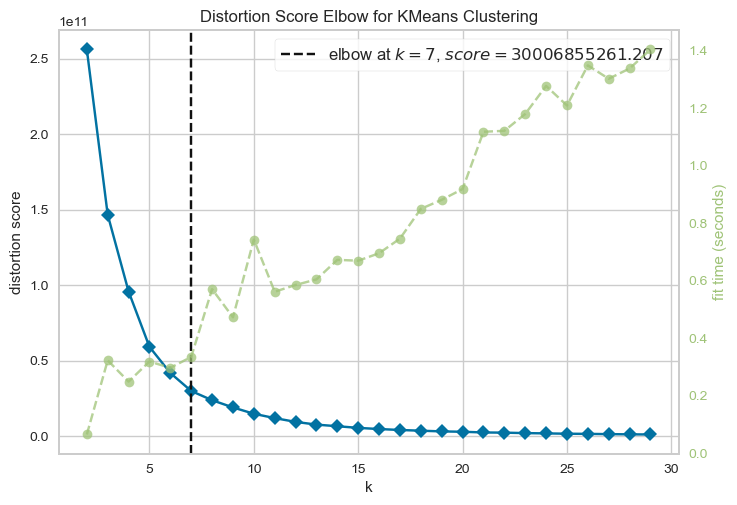

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [237]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
visualizer.fit(pivot_price)       
visualizer.show()        

In [238]:
model = KMeans(n_clusters = 7, random_state = SEED)
train['price_label'] = model.fit_predict(pivot_price.values)

Итог

In [239]:
cat_columns = []
num_columns = []

for column_name in train.columns:
    if (train[column_name].dtypes == object):
        cat_columns +=[column_name]
    else:
        num_columns +=[column_name]

print('Категориальные данные:\t ',cat_columns, '\n Число столблцов = ',len(cat_columns))

print('Числовые данные:\t ',  num_columns, '\n Число столблцов = ',len(num_columns))

Категориальные данные:	  ['building_id', 'description', 'display_address', 'features', 'manager_id', 'photos', 'street_address'] 
 Число столблцов =  7
Числовые данные:	  ['bathrooms', 'bedrooms', 'created', 'latitude', 'listing_id', 'longitude', 'price', 'interest_level', 'num_features', 'num_photos', 'distance_central_park', 'distance_time_square', 'distance_wall_street', 'pets_info', 'doorman_info', 'fitness_info', 'terrace_balcony_info', 'terrace_balcony', 'price_lower_than_2700', 'fee_inf', 'cool_manager', 'created_hour', 'created_mounth', 'created_month', 'price_label'] 
 Число столблцов =  25


## 2.Тестирование различных алгоритмов

In [250]:
features = ['bathrooms',
 'bedrooms',
 'latitude',
 'longitude',
 'price',
 'num_features',
 'num_photos',
 'distance_central_park',
 'distance_time_square',
 'distance_wall_street',
 'pets_info',
 'doorman_info',
 'fitness_info',
 'terrace_balcony',
 'price_lower_than_2700',
 'fee_inf',
 'cool_manager',
 'created_hour',
 'created_month',
 'price_label']
target = ['interest_level']

In [251]:
classifiers = {
    'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=7),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=SEED),
    'RandomForestClassifier': RandomForestClassifier(random_state=SEED),
    'MLPClassifier': MLPClassifier(random_state=SEED),
    'AdaBoostClassifier': AdaBoostClassifier(random_state=SEED),
    'GaussianNB': GaussianNB(),
    'QuadraticDiscriminantAnalysis': QuadraticDiscriminantAnalysis(),
    'XGBClassifier': XGBClassifier(random_state=SEED),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=SEED),
    'CatBoostClassifier': CatBoostClassifier(random_seed = SEED),
    'lg': LogisticRegression(random_state = SEED),
    'scv': LinearSVC(random_state = SEED)
}

С скалером

In [252]:
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train[features])

X = scaled_train
y = train[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = SEED, test_size=0.25)

In [ ]:
df = df = pd.DataFrame(columns=['classifier','f_1','avg_precision_score'])
for name, model in classifiers.items():

    classifier = model
    classifier.fit(X_train, np.ravel(y_train))
    predicts = classifier.predict(X_test)
    f1 = f1_score(y_test, predicts, average='macro')
    average_precision_score = precision_score(y_test, predicts, average='macro')
    df = df.append({'classifier': name,'f_1': f1,'avg_precision_score':average_precision_score}, ignore_index=True)

In [254]:
df.sort_values(by=['f_1'],ascending = False)

classifier       f_1  avg_precision_score
9              CatBoostClassifier  0.551275             0.629226
7                   XGBClassifier  0.549168             0.618978
2          RandomForestClassifier  0.522142             0.602276
3                   MLPClassifier  0.516235             0.589319
1          DecisionTreeClassifier  0.486116             0.487221
8      GradientBoostingClassifier  0.480449             0.623417
4              AdaBoostClassifier  0.476366             0.596048
0            KNeighborsClassifier  0.394452             0.451341
10                             lg  0.340909             0.438851
11                            scv  0.317224             0.348816
6   QuadraticDiscriminantAnalysis  0.167941             0.391269
5                      GaussianNB  0.085020             0.473224

без скалера


In [255]:
X = train[features]
y = train[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = SEED, test_size=0.25)

In [256]:
df = df = pd.DataFrame(columns=['classifier','f_1','avg_precision_score'])
for name, model in classifiers.items():

    classifier = model
    classifier.fit(X_train, np.ravel(y_train))
    predicts = classifier.predict(X_test)
    f1 = f1_score(y_test, predicts, average='macro')
    average_precision_score = precision_score(y_test, predicts, average='macro')
    df = df.append({'classifier': name,'f_1': f1,'avg_precision_score':average_precision_score}, ignore_index=True)
    
df.sort_values(by=['f_1'],ascending = False)

C:\Users\user\AppData\Local\Temp\ipykernel_5440\2130494714.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'classifier': name,'f_1': f1,'avg_precision_score':average_precision_score}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_5440\2130494714.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'classifier': name,'f_1': f1,'avg_precision_score':average_precision_score}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_5440\2130494714.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'classifier': name,'f_1': f1,'avg_precision_score':average_precision_score}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_5440\2130494714.py:9:

Learning rate set to 0.094052
0:	learn: 1.0316906	total: 10.9ms	remaining: 10.9s
1:	learn: 0.9800939	total: 21.1ms	remaining: 10.5s
2:	learn: 0.9377068	total: 30.2ms	remaining: 10s
3:	learn: 0.9018921	total: 40.3ms	remaining: 10s
4:	learn: 0.8732157	total: 49.7ms	remaining: 9.9s
5:	learn: 0.8467942	total: 60.5ms	remaining: 10s
6:	learn: 0.8248502	total: 71.2ms	remaining: 10.1s
7:	learn: 0.8048417	total: 83.3ms	remaining: 10.3s
8:	learn: 0.7891494	total: 93.7ms	remaining: 10.3s
9:	learn: 0.7742684	total: 104ms	remaining: 10.3s
10:	learn: 0.7609884	total: 114ms	remaining: 10.2s
11:	learn: 0.7496921	total: 123ms	remaining: 10.2s
12:	learn: 0.7385456	total: 133ms	remaining: 10.1s
13:	learn: 0.7300931	total: 143ms	remaining: 10.1s
14:	learn: 0.7223345	total: 153ms	remaining: 10s
15:	learn: 0.7154525	total: 162ms	remaining: 9.96s
16:	learn: 0.7091717	total: 175ms	remaining: 10.1s
17:	learn: 0.7028495	total: 185ms	remaining: 10.1s
18:	learn: 0.6987855	total: 195ms	remaining: 10.1s
19:	learn: 

C:\Users\user\AppData\Local\Temp\ipykernel_5440\2130494714.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'classifier': name,'f_1': f1,'avg_precision_score':average_precision_score}, ignore_index=True)
C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\user\AppData\Local\Temp\ipykernel_5440\2130494714.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

classifier       f_1  avg_precision_score
9              CatBoostClassifier  0.551275             0.629226
7                   XGBClassifier  0.549168             0.618978
2          RandomForestClassifier  0.520931             0.600622
1          DecisionTreeClassifier  0.486324             0.487479
8      GradientBoostingClassifier  0.480449             0.623417
4              AdaBoostClassifier  0.476366             0.596048
0            KNeighborsClassifier  0.439832             0.528584
3                   MLPClassifier  0.402639             0.450739
10                             lg  0.311334             0.577844
6   QuadraticDiscriminantAnalysis  0.167941             0.391269
11                            scv  0.154861             0.311900
5                      GaussianNB  0.084997             0.461441

Рассмотрим таблицу корреляции

In [257]:
cm = sns.color_palette("vlag", as_cmap=True)

train[features].corr().style.background_gradient(cmap=cm, vmin = -1, vmax=1)

In [313]:
features_clean = ['bedrooms',
 'bathrooms',
 'latitude',
 'price',
 'num_photos',
 'distance_central_park',
 'pets_info',
 'doorman_info',
 'fitness_info',
 'terrace_balcony',
 'price_lower_than_2700',
 'fee_inf',
 'cool_manager',
 'created_hour',
 'created_month',
 'price_label']

In [259]:
cm = sns.color_palette("vlag", as_cmap=True)

train[features_clean].corr().style.background_gradient(cmap=cm, vmin = -1, vmax=1)

Переобучим с новыми признаками

In [260]:
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train[features_clean])

X = scaled_train
y = train[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = SEED, test_size=0.25)

In [261]:
df = df = pd.DataFrame(columns=['classifier','f_1','avg_precision_score'])
for name, model in classifiers.items():

    classifier = model
    classifier.fit(X_train, np.ravel(y_train))
    predicts = classifier.predict(X_test)
    f1 = f1_score(y_test, predicts, average='macro')
    average_precision_score = precision_score(y_test, predicts, average='macro')
    df = df.append({'classifier': name,'f_1': f1,'avg_precision_score':average_precision_score}, ignore_index=True)
    
df.sort_values(by=['f_1'],ascending = False)

C:\Users\user\AppData\Local\Temp\ipykernel_5440\2130494714.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'classifier': name,'f_1': f1,'avg_precision_score':average_precision_score}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_5440\2130494714.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'classifier': name,'f_1': f1,'avg_precision_score':average_precision_score}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_5440\2130494714.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'classifier': name,'f_1': f1,'avg_precision_score':average_precision_score}, ignore_index=True)
C:\Users\user\anaconda3\lib\site-packages\sklearn\neural_network

Learning rate set to 0.094052
0:	learn: 1.0297098	total: 8.56ms	remaining: 8.56s
1:	learn: 0.9768715	total: 15.9ms	remaining: 7.92s
2:	learn: 0.9355855	total: 23.6ms	remaining: 7.86s
3:	learn: 0.8977032	total: 30.5ms	remaining: 7.59s
4:	learn: 0.8686004	total: 37.7ms	remaining: 7.51s
5:	learn: 0.8430046	total: 46.8ms	remaining: 7.75s
6:	learn: 0.8223160	total: 57.7ms	remaining: 8.18s
7:	learn: 0.8036588	total: 67.1ms	remaining: 8.32s
8:	learn: 0.7865784	total: 76ms	remaining: 8.37s
9:	learn: 0.7715470	total: 83ms	remaining: 8.22s
10:	learn: 0.7590427	total: 90.4ms	remaining: 8.13s
11:	learn: 0.7475001	total: 96.9ms	remaining: 7.97s
12:	learn: 0.7373876	total: 105ms	remaining: 7.96s
13:	learn: 0.7288854	total: 112ms	remaining: 7.91s
14:	learn: 0.7217316	total: 119ms	remaining: 7.79s
15:	learn: 0.7141044	total: 127ms	remaining: 7.82s
16:	learn: 0.7078140	total: 134ms	remaining: 7.73s
17:	learn: 0.7036541	total: 141ms	remaining: 7.69s
18:	learn: 0.6989133	total: 148ms	remaining: 7.65s
19:

C:\Users\user\AppData\Local\Temp\ipykernel_5440\2130494714.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'classifier': name,'f_1': f1,'avg_precision_score':average_precision_score}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_5440\2130494714.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'classifier': name,'f_1': f1,'avg_precision_score':average_precision_score}, ignore_index=True)
C:\Users\user\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\user\AppData\Local\Temp\ipykernel_5440\2130494714.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = 

classifier       f_1  avg_precision_score
9              CatBoostClassifier  0.544900             0.626436
7                   XGBClassifier  0.542988             0.622147
2          RandomForestClassifier  0.519778             0.601245
1          DecisionTreeClassifier  0.485764             0.486612
8      GradientBoostingClassifier  0.468390             0.614457
3                   MLPClassifier  0.465324             0.571010
4              AdaBoostClassifier  0.456171             0.574749
0            KNeighborsClassifier  0.398043             0.456088
10                             lg  0.334458             0.438453
11                            scv  0.313362             0.346196
6   QuadraticDiscriminantAnalysis  0.161087             0.389848
5                      GaussianNB  0.129788             0.445280

## 3.Отбор признаков

In [327]:
train.longitude = train.longitude.apply(lambda x: -x)

In [314]:
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train[features_clean])

X = scaled_train
y = train[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = SEED, test_size=0.25)

In [ ]:
clf = CatBoostClassifier(random_seed = SEED)
clf = clf.fit(X_train, np.ravel(y_train))

values = clf.feature_importances_   
idx = features_clean
plt.figure(figsize=(10,8))
clrs = ['pink' if x > 3 else 'red' for x in values]
sns.barplot(y=idx,x=values,palette=clrs).set(title='Сила признаков')
plt.show()

In [319]:
strong_features_clean = [key for key,value in dict(zip(features_clean, clf.feature_importances_ )).items() if value > 4]
strong_features_clean

['bathrooms',
 'latitude',
 'price',
 'num_photos',
 'distance_central_park',
 'pets_info',
 'doorman_info',
 'fitness_info',
 'terrace_balcony',
 'price_label']

In [317]:
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train[features])

X = scaled_train
y = train[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = SEED, test_size=0.25)

Learning rate set to 0.094052
0:	learn: 1.0316906	total: 10.2ms	remaining: 10.2s
1:	learn: 0.9800939	total: 18.4ms	remaining: 9.17s
2:	learn: 0.9377068	total: 26.2ms	remaining: 8.71s
3:	learn: 0.9018921	total: 34.4ms	remaining: 8.57s
4:	learn: 0.8732157	total: 42.5ms	remaining: 8.46s
5:	learn: 0.8467942	total: 51.2ms	remaining: 8.48s
6:	learn: 0.8248502	total: 58.9ms	remaining: 8.36s
7:	learn: 0.8048417	total: 67.2ms	remaining: 8.34s
8:	learn: 0.7891494	total: 75.4ms	remaining: 8.31s
9:	learn: 0.7742684	total: 83ms	remaining: 8.22s
10:	learn: 0.7609884	total: 91.8ms	remaining: 8.25s
11:	learn: 0.7496921	total: 99.3ms	remaining: 8.18s
12:	learn: 0.7385456	total: 107ms	remaining: 8.15s
13:	learn: 0.7300931	total: 115ms	remaining: 8.13s
14:	learn: 0.7223345	total: 124ms	remaining: 8.14s
15:	learn: 0.7154525	total: 131ms	remaining: 8.07s
16:	learn: 0.7091717	total: 140ms	remaining: 8.12s
17:	learn: 0.7028495	total: 148ms	remaining: 8.1s
18:	learn: 0.6987855	total: 157ms	remaining: 8.1s
19:

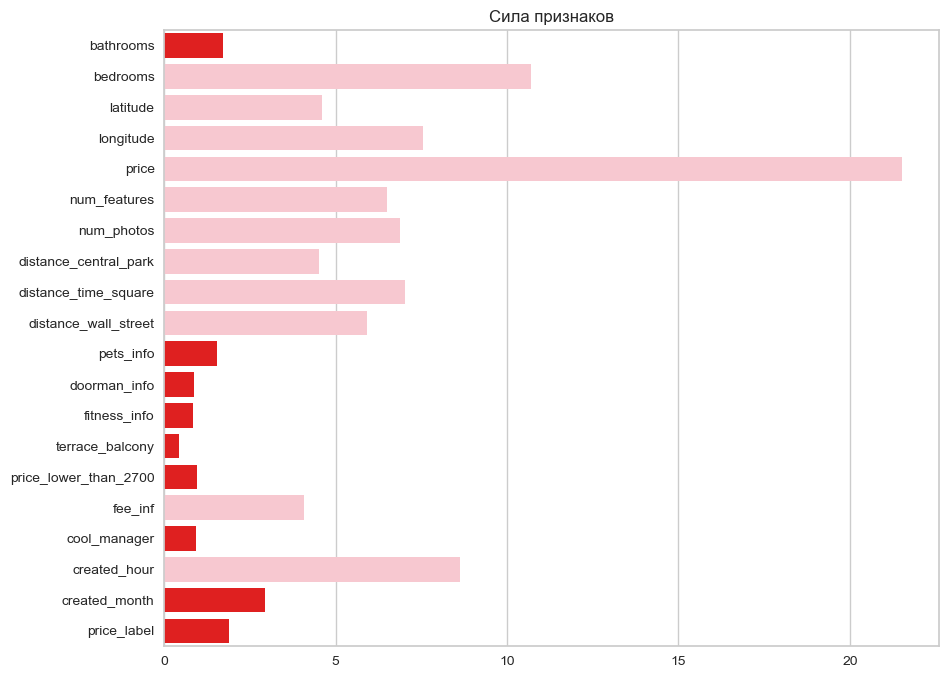

In [318]:
clf = CatBoostClassifier(random_seed = SEED)
clf = clf.fit(X_train, np.ravel(y_train))

values = clf.feature_importances_   
idx = features
plt.figure(figsize=(10,8))
clrs = ['pink' if x > 3 else 'red' for x in values]
sns.barplot(y=idx,x=values,palette=clrs).set(title='Сила признаков')
plt.show()

In [322]:
strong_features = [key for key,value in dict(zip(features, clf.feature_importances_ )).items() if value > 5]
strong_features

['bedrooms',
 'longitude',
 'price',
 'num_features',
 'num_photos',
 'distance_time_square',
 'distance_wall_street',
 'created_hour']

чи бест

In [325]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=11)
fit = bestfeatures.fit(train[features_clean],y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(train[features_clean].columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
strong_features_2_clean = featureScores.nlargest(11,'Score').Specs.values.tolist()
strong_features_2_clean

['price',
 'created_hour',
 'distance_central_park',
 'price_lower_than_2700',
 'fee_inf',
 'doorman_info',
 'cool_manager',
 'pets_info',
 'fitness_info',
 'bathrooms',
 'bedrooms']

In [329]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=11)
fit = bestfeatures.fit(train[features],y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(train[features].columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
strong_features_2 = featureScores.nlargest(11,'Score').Specs.values.tolist()
strong_features_2

['price',
 'distance_time_square',
 'distance_wall_street',
 'created_hour',
 'distance_central_park',
 'price_lower_than_2700',
 'fee_inf',
 'num_features',
 'doorman_info',
 'cool_manager',
 'pets_info']

ExtraTree

C:\Users\user\AppData\Local\Temp\ipykernel_5440\3738329190.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  extra_tree_forest.fit(train[features_clean], y)


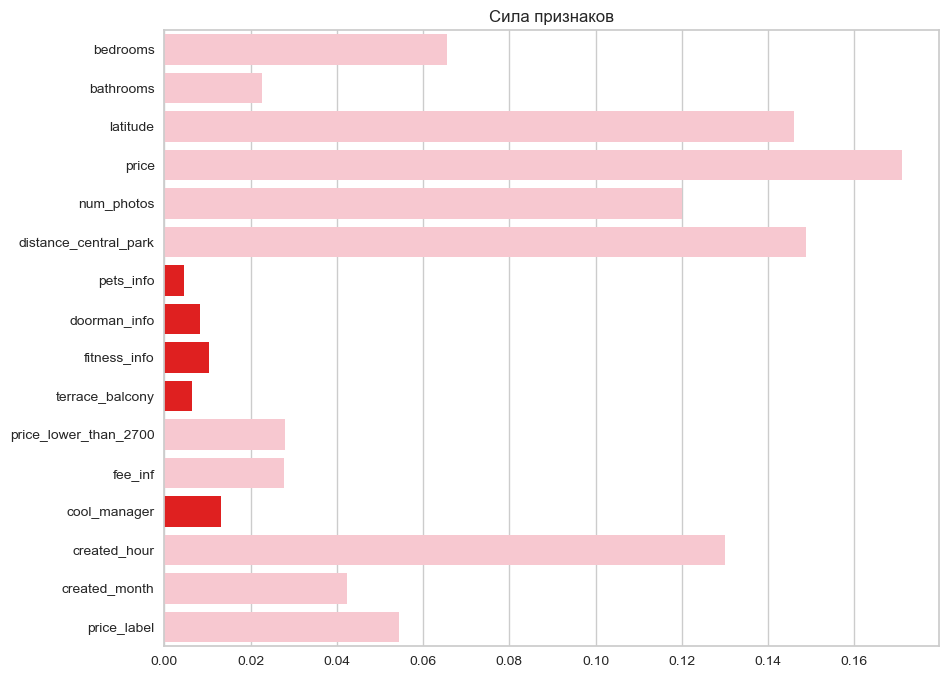

In [330]:
from sklearn.ensemble import ExtraTreesClassifier
extra_tree_forest = ExtraTreesClassifier(n_estimators = 5,
                                        criterion ='entropy', max_features = 2)
  
extra_tree_forest.fit(train[features_clean], y)
feature_importance = extra_tree_forest.feature_importances_

values = feature_importance   
idx = features_clean
plt.figure(figsize=(10,8))
clrs = ['pink' if x > 0.02 else 'red' for x in values ]
sns.barplot(y=idx,x=values,palette=clrs).set(title='Сила признаков')
plt.show()

In [333]:
strong_features_3_clean = [key for key,values in dict(zip(features_clean, feature_importance)).items() if values > 0.04]
strong_features_3_clean

['bedrooms',
 'latitude',
 'price',
 'num_photos',
 'distance_central_park',
 'created_hour',
 'created_month',
 'price_label']

C:\Users\user\AppData\Local\Temp\ipykernel_5440\3903177320.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  extra_tree_forest.fit(train[features], y)


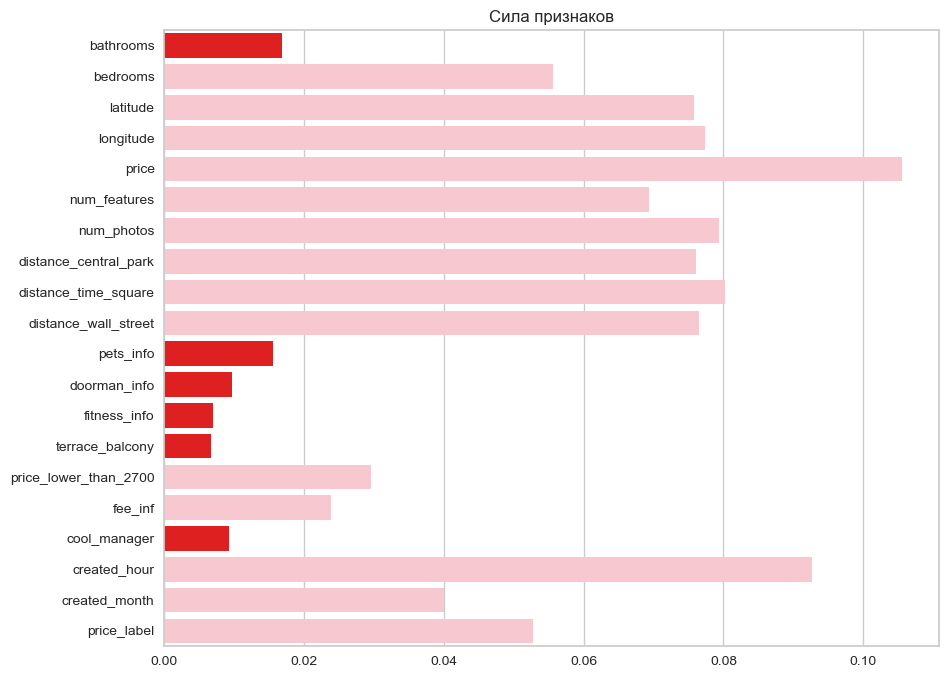

In [334]:
extra_tree_forest = ExtraTreesClassifier(n_estimators = 5,
                                        criterion ='entropy', max_features = 2)
  
extra_tree_forest.fit(train[features], y)
feature_importance = extra_tree_forest.feature_importances_

values = feature_importance   
idx = features
plt.figure(figsize=(10,8))
clrs = ['pink' if x > 0.02 else 'red' for x in values ]
sns.barplot(y=idx,x=values,palette=clrs).set(title='Сила признаков')
plt.show()

In [336]:
strong_features_3 = [key for key,values in dict(zip(features, feature_importance)).items() if values >= 0.04]
strong_features_3

['bedrooms',
 'latitude',
 'longitude',
 'price',
 'num_features',
 'num_photos',
 'distance_central_park',
 'distance_time_square',
 'distance_wall_street',
 'created_hour',
 'created_month',
 'price_label']

RFE

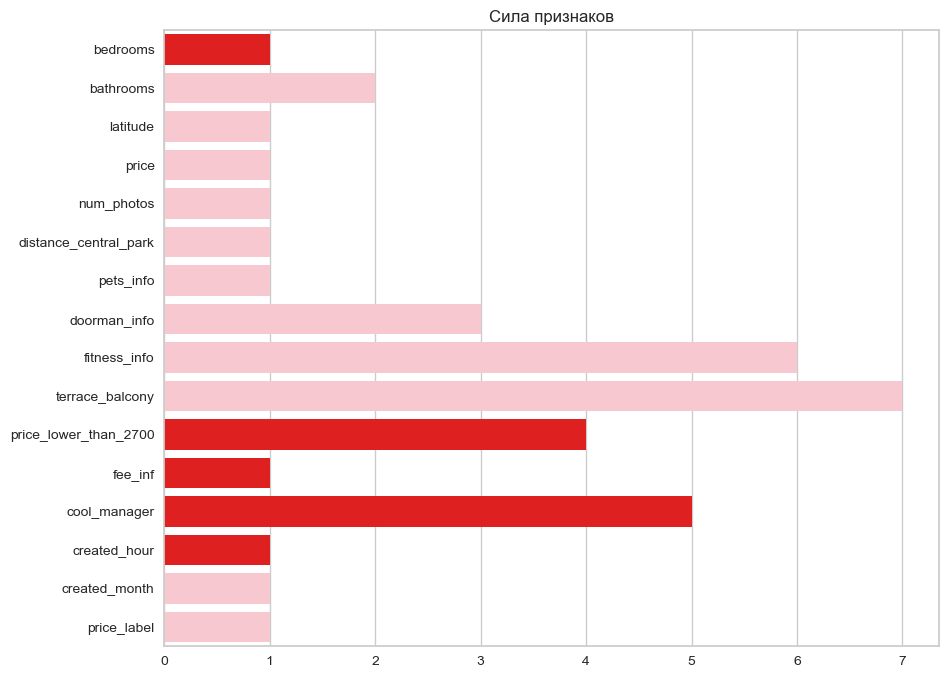

In [337]:
from sklearn.feature_selection import RFE
selector = RFE(RandomForestClassifier(random_state=SEED), n_features_to_select=10, step=1)
selector = selector.fit(train[features_clean], np.ravel(y))
selector.ranking_

values = selector.ranking_   
idx = features_clean
plt.figure(figsize=(10,8))
#clrs = ['pink' if x > 0.02 else 'red' for x in values ]
sns.barplot(y=idx,x=values,palette=clrs).set(title='Сила признаков')
plt.show()

In [338]:
strong_features_4_clean = [key for key,values in dict(zip(features_clean, selector.ranking_ )).items() if values >= 2]
strong_features_4_clean

['bathrooms',
 'doorman_info',
 'fitness_info',
 'terrace_balcony',
 'price_lower_than_2700',
 'cool_manager']

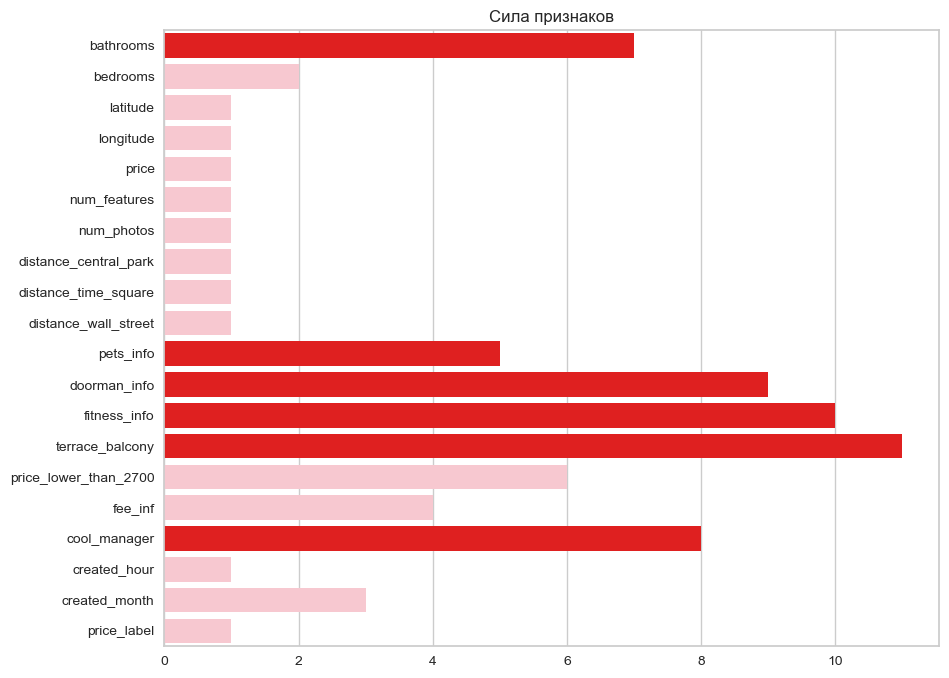

In [339]:
selector = RFE(RandomForestClassifier(random_state=SEED), n_features_to_select=10, step=1)
selector = selector.fit(train[features], np.ravel(y))
selector.ranking_

values = selector.ranking_   
idx = features
plt.figure(figsize=(10,8))
#clrs = ['pink' if x > 0.02 else 'red' for x in values ]
sns.barplot(y=idx,x=values,palette=clrs).set(title='Сила признаков')
plt.show()

In [340]:
strong_features_4 = [key for key,values in dict(zip(features, selector.ranking_ )).items() if values >= 4]
strong_features_4

['bathrooms',
 'pets_info',
 'doorman_info',
 'fitness_info',
 'terrace_balcony',
 'price_lower_than_2700',
 'fee_inf',
 'cool_manager']

In [ ]:
features_list = {'str_features':strong_features,'strong_features_2':strong_features_2,'strong_features_3':strong_features_3,'strong_features_4':strong_features_4,
                 'str_features_clean':strong_features_clean,'strong_features_2_clean':strong_features_2_clean,'strong_features_3_clean':strong_features_3_clean,'strong_features_4_clean':strong_features_4_clean}
total_df = pd.DataFrame(columns=['classifier','f_1','avg_precision_score'])
for name, model in classifiers.items():
    for key,value in features_list.items():
      scaled_train = scaler.fit_transform(train[value])
      X = scaled_train
      y = train[target]
      X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = SEED, test_size=0.25)
      classifier = model
      classifier.fit(X_train, np.ravel(y_train))
      predicts = classifier.predict(X_test)
      f1 = f1_score(y_test, predicts, average='macro')
      average_precision_score = precision_score(y_test, predicts, average='macro')
      total_df = total_df.append({'classifier': name + '_' + key,'f_1': f1,'avg_precision_score':average_precision_score}, ignore_index=True)

In [372]:
total_df.sort_values(by='f_1',ascending=False).head(10)

classifier       f_1  avg_precision_score
72           CatBoostClassifier_str_features  0.540833             0.626819
56                XGBClassifier_str_features  0.537020             0.620055
74      CatBoostClassifier_strong_features_3  0.535146             0.615641
58           XGBClassifier_strong_features_3  0.534439             0.611737
18  RandomForestClassifier_strong_features_3  0.527041             0.603744
..                                       ...       ...                  ...
44             GaussianNB_str_features_clean  0.125624             0.433832
46        GaussianNB_strong_features_3_clean  0.111986             0.447636
40                   GaussianNB_str_features  0.088787             0.449470
41              GaussianNB_strong_features_2  0.087390             0.464140
42              GaussianNB_strong_features_3  0.078659             0.459630

[96 rows x 3 columns]

## 4.Подбор гиперпараметров

**cat**

In [450]:
def objective_cat(trial):   
    param = {
        'iterations': trial.suggest_categorical('iterations', [300, 500, 700]), 
        'verbose': 0, #
        'random_seed': SEED,
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 5, 8),
        'classes_count': 3,
        #'text_features': ['description'],
        'early_stopping_rounds' : 10,
        'learning_rate': trial.suggest_categorical('learning_rate', [0.05, 0.1, 0.15, 0.2]),
        'max_depth': trial.suggest_categorical('max_depth', [5, 6, 7, 8])
    }
    model = CatBoostClassifier(**param)  
    
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    
    f1 = f1_score(y_test, preds, average='macro')
    
    return f1

In [451]:
X = train[features]
y = train[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = SEED, test_size=0.25)

In [ ]:
# sampler=optuna.samplers.TPESampler(seed=SEED) нужен для повторения результатов при перезапуске
study_cat = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=SEED))

# Здесь n_trials показывает, сколько раз будет построена модель со случайными параметрами

study_cat.optimize(objective_cat, n_trials=100)

In [453]:
print('Параметры, полученные при лучшей оценке:', study_cat.best_trial.params)

Параметры, полученные при лучшей оценке: {'iterations': 700, 'l2_leaf_reg': 6.480844974809641, 'learning_rate': 0.1, 'max_depth': 8}


**XGB**

In [454]:
param_grid = { 
    "learning_rate": [0.01, 0.1, 0.5, 1],
    "colsample_bytree": [ 0.3, 0.5 , 0.8 ],
    "n_estimators": [75, 100, 150],
    "max_depth": [3, 4, 5],
    "reg_alpha": [0, 0.5, 1, 5],
    "reg_lambda": [0, 0.5, 1, 5]
    }
scoring = 'f1_macro'
kfold = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=SEED)

In [455]:
random_search = RandomizedSearchCV(estimator=xgboost, 
                           param_distributions=param_grid, 
                           n_iter=48,
                           scoring='f1_macro' , 
                           n_jobs=-1, 
                           cv=kfold, 
                           verbose=0)
random_result  = random_search.fit(X_train, y_train)
random_result

RandomizedSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=666, test_size=0.2,
            train_size=None),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                 

In [456]:
random_result.best_params_

{'reg_lambda': 5,
 'reg_alpha': 5,
 'n_estimators': 150,
 'max_depth': 5,
 'learning_rate': 1,
 'colsample_bytree': 0.8}

In [457]:
pred = random_result.predict(X_test)
f1_score(y_test, pred, average='macro')

0.5537532085846372

XGB_OPTUNA

In [458]:
space = {
    'learning_rate': hp.choice('learning_rate', [0.0001,0.001, 0.01, 0.1, 1]),
    'max_depth' : hp.choice('max_depth', range(3,21,3)),
    'gamma' : hp.choice('gamma', [i/10.0 for i in range(0,5)]),
    'colsample_bytree' : hp.choice('colsample_bytree', [i/10.0 for i in range(3,10)]),     
    'reg_alpha' : hp.choice('reg_alpha', [1e-5, 1e-2, 0.1, 1, 10, 100]), 
    "n_estimators": hp.choice('n_estimators',range(50,100,10)),
    'reg_lambda' : hp.choice('reg_lambda', [1e-5, 1e-2, 0.1, 1, 10, 100])
}
kfold = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=SEED)

In [459]:
def objective(params):
    
    xgboost = XGBClassifier(seed=SEED, **params)
    score = cross_val_score(estimator=xgboost, 
                            X=X_train, 
                            y=y_train, 
                            cv=kfold, 
                            scoring='f1_macro', 
                            n_jobs=-1).mean()
    # Loss is negative score
    loss = - score
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [460]:
best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = 48, trials = Trials())

100%|███████████████████████████████████████████████| 48/48 [07:53<00:00,  9.87s/trial, best loss: -0.5441301161955445]


In [461]:
print(space_eval(space, best))

{'colsample_bytree': 0.5, 'gamma': 0.1, 'learning_rate': 1, 'max_depth': 9, 'n_estimators': 70, 'reg_alpha': 10, 'reg_lambda': 1}


In [462]:
xgboost_bo = XGBClassifier(seed=SEED, 
                           colsample_bytree=space_eval(space, best)['colsample_bytree'], 
                           gamma=space_eval(space, best)['gamma'], 
                           learning_rate=space_eval(space, best)['learning_rate'], 
                           max_depth=space_eval(space, best)['max_depth'], 
                           reg_alpha=space_eval(space, best)['reg_alpha'],
                           reg_lambda=space_eval(space, best)['reg_lambda']
                           ).fit(X_train,y_train)

In [421]:
pred = xgboost_bo.predict(X_test)
f1_score(y_test, pred, average='macro')

0.545895185061196

**RANDOM_FOREST**

In [463]:

n_estimators = [50,75,100,125,150,175,200,225,250,275,300]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier(random_state=SEED)

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = kfold, verbose=2, random_state=SEED, n_jobs = -1)
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=666, test_size=0.2,
            train_size=None),
                   estimator=RandomForestClassifier(random_state=666),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 75, 100, 125, 150,
                                                         175, 200, 225, 250,
                                                         275, 300]},
                   random_state=666, ver

In [464]:
rf_random.best_params_

{'n_estimators': 175,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20,
 'bootstrap': True}

In [465]:
pred = rf_random.predict(X_test)
f1_score(y_test, pred, average='macro')

0.5146328320403765

**ИТОГ**

In [466]:
cat_boost_clf = CatBoostClassifier(iterations= 700,l2_leaf_reg= 6.480844974809641, learning_rate= 0.1, max_depth= 8,random_state = SEED) #0.5478396067503329
xgb_random_clf = random_result #0.5390304498404146
xgb_optuna_clf = xgboost_bo #0.545895185061196
rf_random_clf = RandomForestClassifier(n_estimators = rf_random.best_params_['n_estimators'],min_samples_split =rf_random.best_params_['min_samples_split'],min_samples_leaf =rf_random.best_params_['min_samples_leaf'],
                                       max_features =rf_random.best_params_['max_features'],max_depth = rf_random.best_params_['max_depth'],bootstrap = True)

## 5.Стекинг алгоритмов

**votingclf**

In [467]:
from sklearn.ensemble import VotingClassifier

In [ ]:
vote_clf = VotingClassifier(
    estimators=[('cat', cat_boost_clf), ('rf', rf_random_clf), ('xgb', xgb_optuna_clf)],
    voting='soft')
vote_clf.fit(X_train, y_train)

In [469]:
pred = vote_clf.predict(X_test)
f1_score(y_test, pred, average='macro')

0.5480373749199944

**stackingclf**

In [470]:
from sklearn.ensemble import StackingClassifier

In [471]:
stacking_clf = StackingClassifier(estimators=[('cat', cat_boost_clf), ('rf', rf_random_clf), ('xgb', xgb_optuna_clf)], final_estimator=LogisticRegression())
stacking_clf.fit(X_train, y_train)
pred = stacking_clf.predict(X_test)
f1_score(y_test, pred, average='macro')

C:\Users\user\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0:	learn: 0.9656550	total: 28.9ms	remaining: 20.2s
1:	learn: 0.8849113	total: 54.1ms	remaining: 18.9s
2:	learn: 0.8274596	total: 78.3ms	remaining: 18.2s
3:	learn: 0.7866645	total: 103ms	remaining: 18s
4:	learn: 0.7575374	total: 128ms	remaining: 17.8s
5:	learn: 0.7321565	total: 154ms	remaining: 17.8s
6:	learn: 0.7147116	total: 183ms	remaining: 18.1s
7:	learn: 0.7008576	total: 208ms	remaining: 18s
8:	learn: 0.6876622	total: 235ms	remaining: 18s
9:	learn: 0.6773613	total: 261ms	remaining: 18s
10:	learn: 0.6687117	total: 286ms	remaining: 17.9s
11:	learn: 0.6611069	total: 309ms	remaining: 17.7s
12:	learn: 0.6532567	total: 333ms	remaining: 17.6s
13:	learn: 0.6466363	total: 357ms	remaining: 17.5s
14:	learn: 0.6436726	total: 380ms	remaining: 17.4s
15:	learn: 0.6394970	total: 407ms	remaining: 17.4s
16:	learn: 0.6359084	total: 433ms	remaining: 17.4s
17:	learn: 0.6321195	total: 460ms	remaining: 17.4s
18:	learn: 0.6300711	total: 489ms	remaining: 17.5s
19:	learn: 0.6278948	total: 517ms	remaining: 1

0.5599048838589843

## 6.Добавление кластера в качестве признака

Кластеризация проведена по price в ходе добавления новых фич

## 7.Итоговый сабмит

In [549]:
test.description = test.description.fillna('empty')
test = test.fillna(0)

test['num_features']=test['features'].str.replace('[\[\]\']', '').str.split(', ').apply(len)
test['num_photos']=test['photos'].str.replace('[\[\]\']', '').str.split(', ').apply(len)

central_park = tuple([40.7736,-73.9727]) #Координаты центрального парка
time_square = tuple([40.7577,-73.9857])  #Координаты тайм-сквера
wall_street = tuple([40.7072,-74.0116])   #Координаты уолл-стрит

test['distance_central_park'] = train.latitude
test['distance_time_square'] = train.latitude
test['distance_wall_street'] = train.latitude

for i in range(test.shape[0]):
  test.distance_central_park.iloc[i] = geodesic((test.latitude.iloc[i],test.longitude.iloc[i]),central_park).miles

for i in range(test.shape[0]):
  test.distance_time_square.iloc[i] = geodesic((test.latitude.iloc[i],test.longitude.iloc[i]),time_square).miles

for i in range(test.shape[0]):
  test.distance_wall_street.iloc[i] = geodesic((test.latitude.iloc[i],test.longitude.iloc[i]),wall_street).miles

test['fitness_info'] = test['features'].str.replace('[\[\]\']', '').str.split(',').apply(lambda x: 1 if ('fitness' in set([word.lower().strip() for line in x for word in line.split()])
                                                                                                        or 'gym' in set([word.lower().strip() for line in x for word in line.split()])
                                                                                                        ) else 0)

test['terrace_balcony'] = test['features'].str.replace('[\[\]\']', '').str.split(',').apply(lambda x: 1 if ('balcony' in set([word.lower().strip() for line in x for word in line.split()])
                                                                                                        or 'terrace' in set([word.lower().strip() for line in x for word in line.split()])
                                                                                                        ) else 0)


test['pets_info'] = test['features'].str.replace('[\[\]\']', '').str.split(',').apply(lambda x: 1 if (' No Pets' in x
                                                                                                        or ' Pet friendly' in x
                                                                                                        or ' pets ok' in x 
                                                                                                        or 'pets' in x
                                                                                                        or ' Pets Allowed' in x
                                                                                                        or ' Dogs OK' in x
                                                                                                        or ' Pet friendly ( case by case )' in x
                                                                                                        or ' Pets Upon Approval' in x
                                                                                                        or ' All pets ok' in x
                                                                                                        or ' pets' in x
                                                                                                        or 'No pets' in x
                                                                                                        or ' Cats Allowed' in x
                                                                                                        or ' Dogs Allowed' in x
                                                                                                        or 'Dogs Allowed' in x
                                                                                                        or 'Cats Allowed' in x) else 0)

test['doorman_info'] = test['features'].str.replace('[\[\]\']', '').str.split(',').apply(lambda x: 1 if ('doorman' in set([word.lower().strip() for line in x for word in line.split()])
                                                                                                        or 'oncierge' in set([word.lower().strip() for line in x for word in line.split()])
                                                                                                        #or 'Concierge' in x 
                                                                                                        #or 'Doorman' in x
                                                                                                        ) else 0)
test['fee_inf'] = test['features'].str.replace('[\[\]\']', '').str.split(',').apply(lambda x: 1 if ('fee' in set([word.lower().strip() for line in x for word in line.split()])) else 0)

test['price_lower_than_2700'] = test.price.apply(lambda x: 1 if x < 2700 else 0)

cool_managers = []
for key,value in test.manager_id.value_counts().to_dict().items():
  if value >= 100:
    cool_managers.append(key)
test['cool_manager'] = test['manager_id'].apply(lambda x: 1 if x in cool_managers else 0)

test["created"] = pd.to_datetime(test["created"])
test["created_hour"] = test.created.dt.hour
test["created_month"] = test.created.dt.month

model = KMeans(n_clusters = 7, random_state = SEED)
test['price_label'] = model.fit_predict(pd.pivot_table(test, index = ['listing_id'],  values = 'price').values)

C:\Users\user\AppData\Local\Temp\ipykernel_5440\3538079059.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  test['num_features']=test['features'].str.replace('[\[\]\']', '').str.split(', ').apply(len)
C:\Users\user\AppData\Local\Temp\ipykernel_5440\3538079059.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  test['num_photos']=test['photos'].str.replace('[\[\]\']', '').str.split(', ').apply(len)
C:\Users\user\AppData\Local\Temp\ipykernel_5440\3538079059.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.distance_central_park.iloc[i] = geodesic((test.latitude.iloc[i],test.longitude.iloc[i]),central_park).miles
C:\Users\user\AppData\Local\Temp\ipykernel_5440\3538079059.py:19: SettingWithCopyWar

In [476]:
features = ['bathrooms','bedrooms','latitude','longitude','price', 'num_features', 'num_photos', 'distance_central_park', 'distance_time_square', 'distance_wall_street', 'pets_info', 'doorman_info', 'fitness_info',
 'terrace_balcony', 'price_lower_than_2700', 'fee_inf', 'cool_manager', 'created_hour', 'created_month', 'price_label']

features_clean = ['bedrooms', 'bathrooms', 'latitude', 'price', 'num_photos', 'distance_central_park', 'pets_info', 'doorman_info', 'fitness_info', 'terrace_balcony', 'price_lower_than_2700',
 'fee_inf', 'cool_manager', 'created_hour', 'created_month', 'price_label']

strong_features = ['bedrooms', 'longitude', 'price', 'num_features', 'num_photos', 'distance_time_square', 'distance_wall_street', 'created_hour']
target = ['interest_level']

In [477]:
scaled_train = scaler.fit_transform(train[features])
X = scaled_train
y = train[target]
cat_boost_clf.fit(X,y)

0:	learn: 0.9650776	total: 33.3ms	remaining: 23.3s
1:	learn: 0.8844146	total: 65.1ms	remaining: 22.7s
2:	learn: 0.8280075	total: 97.2ms	remaining: 22.6s
3:	learn: 0.7873841	total: 129ms	remaining: 22.5s
4:	learn: 0.7589996	total: 162ms	remaining: 22.5s
5:	learn: 0.7329164	total: 192ms	remaining: 22.2s
6:	learn: 0.7157739	total: 220ms	remaining: 21.8s
7:	learn: 0.6984483	total: 248ms	remaining: 21.4s
8:	learn: 0.6876292	total: 289ms	remaining: 22.2s
9:	learn: 0.6771990	total: 318ms	remaining: 21.9s
10:	learn: 0.6685005	total: 345ms	remaining: 21.6s
11:	learn: 0.6614079	total: 373ms	remaining: 21.4s
12:	learn: 0.6552668	total: 400ms	remaining: 21.1s
13:	learn: 0.6496221	total: 426ms	remaining: 20.9s
14:	learn: 0.6464752	total: 454ms	remaining: 20.7s
15:	learn: 0.6415371	total: 485ms	remaining: 20.7s
16:	learn: 0.6371554	total: 513ms	remaining: 20.6s
17:	learn: 0.6339760	total: 541ms	remaining: 20.5s
18:	learn: 0.6309410	total: 568ms	remaining: 20.4s
19:	learn: 0.6277407	total: 596ms	rema

In [495]:
scaled_test = scaler.fit_transform(test[features])
test['interest_level']=cat_boost_clf.predict(scaled_test)
test[['listing_id', 'interest_level']].to_csv('sub_chernykh_catboost.csv', index=None)

In [496]:
xgb_random_clf.fit(X,y)
scaled_test = scaler.fit_transform(test[features])
test['interest_level']=xgb_random_clf.predict(scaled_test)
test[['listing_id', 'interest_level']].to_csv('sub_chernykh_xgb_random.csv', index=None)

In [497]:
xgb_optuna_clf.fit(X,y)
scaled_test = scaler.fit_transform(test[features])
test['interest_level']=xgb_optuna_clf.predict(scaled_test)
test[['listing_id', 'interest_level']].to_csv('sub_chernykh_xgb_optuna.csv', index=None)

In [498]:
rf_random_clf.fit(X,y)
scaled_test = scaler.fit_transform(test[features])
test['interest_level']=rf_random_clf.predict(scaled_test)
test[['listing_id', 'interest_level']].to_csv('sub_chernykh_rf_random.csv', index=None)

C:\Users\user\AppData\Local\Temp\ipykernel_5440\1352666179.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_random_clf.fit(X,y)


In [499]:
vote_clf.fit(X,y)
scaled_test = scaler.fit_transform(test[features])
test['interest_level']=vote_clf.predict(scaled_test)
test[['listing_id', 'interest_level']].to_csv('sub_chernykh_vote_clf.csv', index=None)

C:\Users\user\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0:	learn: 0.9650776	total: 37.1ms	remaining: 26s
1:	learn: 0.8844146	total: 67.1ms	remaining: 23.4s
2:	learn: 0.8280075	total: 97.1ms	remaining: 22.6s
3:	learn: 0.7873841	total: 127ms	remaining: 22.1s
4:	learn: 0.7589996	total: 157ms	remaining: 21.9s
5:	learn: 0.7329164	total: 189ms	remaining: 21.8s
6:	learn: 0.7157739	total: 220ms	remaining: 21.8s
7:	learn: 0.6984483	total: 249ms	remaining: 21.5s
8:	learn: 0.6876292	total: 282ms	remaining: 21.7s
9:	learn: 0.6771990	total: 314ms	remaining: 21.6s
10:	learn: 0.6685005	total: 345ms	remaining: 21.6s
11:	learn: 0.6614079	total: 376ms	remaining: 21.6s
12:	learn: 0.6552668	total: 412ms	remaining: 21.8s
13:	learn: 0.6496221	total: 445ms	remaining: 21.8s
14:	learn: 0.6464752	total: 484ms	remaining: 22.1s
15:	learn: 0.6415371	total: 517ms	remaining: 22.1s
16:	learn: 0.6371554	total: 549ms	remaining: 22.1s
17:	learn: 0.6339760	total: 580ms	remaining: 22s
18:	learn: 0.6309410	total: 613ms	remaining: 22s
19:	learn: 0.6277407	total: 685ms	remaining:

In [500]:
stacking_clf.fit(X,y)
scaled_test = scaler.fit_transform(test[features])
test['interest_level']=stacking_clf.predict(scaled_test)
test[['listing_id', 'interest_level']].to_csv('sub_chernykh_stacking_clf.csv', index=None)

C:\Users\user\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0:	learn: 0.9650776	total: 42.4ms	remaining: 29.6s
1:	learn: 0.8844146	total: 91.1ms	remaining: 31.8s
2:	learn: 0.8280075	total: 131ms	remaining: 30.5s
3:	learn: 0.7873841	total: 172ms	remaining: 29.9s
4:	learn: 0.7589996	total: 205ms	remaining: 28.4s
5:	learn: 0.7329164	total: 240ms	remaining: 27.7s
6:	learn: 0.7157739	total: 272ms	remaining: 27s
7:	learn: 0.6984483	total: 305ms	remaining: 26.4s
8:	learn: 0.6876292	total: 339ms	remaining: 26s
9:	learn: 0.6771990	total: 373ms	remaining: 25.8s
10:	learn: 0.6685005	total: 406ms	remaining: 25.5s
11:	learn: 0.6614079	total: 440ms	remaining: 25.2s
12:	learn: 0.6552668	total: 469ms	remaining: 24.8s
13:	learn: 0.6496221	total: 499ms	remaining: 24.4s
14:	learn: 0.6464752	total: 527ms	remaining: 24.1s
15:	learn: 0.6415371	total: 555ms	remaining: 23.7s
16:	learn: 0.6371554	total: 582ms	remaining: 23.4s
17:	learn: 0.6339760	total: 609ms	remaining: 23.1s
18:	learn: 0.6309410	total: 641ms	remaining: 23s
19:	learn: 0.6277407	total: 679ms	remaining: 

# ***РУБРИКА ЭКСПЕРИМЕНТЫ***

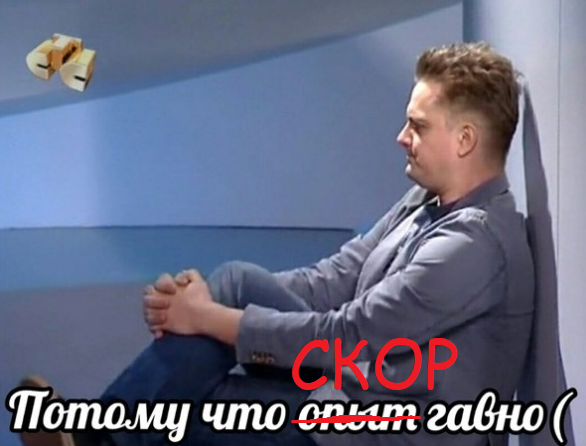

In [ ]:
cat_clf = CatBoostClassifier(random_state=SEED,cat_features=cat_columns)
cat_clf.fit(train[cat_features],train['interest_level'])

In [536]:
cat_clf.feature_importances_

array([ 1.20708341,  7.69540623, 10.30499941,  5.0882112 ,  6.0932046 ,
        7.73238461,  7.19671316,  6.09795617, 14.80402693, 17.16563238,
        3.6236214 ,  4.04458545,  2.58655148,  3.99652771,  2.36309587])

In [535]:
test['interest_level']=cat_clf.predict(test[cat_features])
test[['listing_id', 'interest_level']].to_csv('sub_chernykh_cat.csv', index=None)

In [ ]:
dict(zip(cat_features, cat_clf.feature_importances_ ))

In [ ]:
cat_features_new = [key for key,value in dict(zip(cat_features, cat_clf.feature_importances_ )).items() if value > 6 ]
cat_features_new

In [ ]:
cat_clf = CatBoostClassifier(random_state=SEED,cat_features=['building_id','display_address','features','manager_id'])
cat_clf.fit(train[cat_features_new],train['interest_level'])

In [546]:
test['interest_level']=cat_clf.predict(test[cat_features_new])
test[['listing_id', 'interest_level']].to_csv('sub_chernykh_cat_strong_features.csv', index=None)

In [600]:
X = train_cat
y = train['interest_level']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=SEED)

Пихнуть словарь переобучения
   сделать векторизацию

In [610]:
def objective_cat(trial):   
    param = {
        'iterations': trial.suggest_categorical('iterations', [1000, 1100, 1200, 1300]), 
        'verbose': 0,
        'random_seed': SEED,
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 4, 8),
        'classes_count': 3,
        'early_stopping_rounds' : 10,
        'cat_features': cat_columns,
        'learning_rate': trial.suggest_categorical('learning_rate', [0.05, 0.1, 0.15, 0.2]),
        'max_depth': trial.suggest_categorical('max_depth', [5, 6, 7, 8])
    }
    model = CatBoostClassifier(**param)  
    
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    
    f1 = f1_score(y_test, preds, average='macro')
    
    return f1

In [ ]:
%%timeit
study_cat = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=SEED))
study_cat.optimize(objective_cat, n_trials=100)

мисскликнул и обучение заного создалось, лучшие результаты ниже в словаре

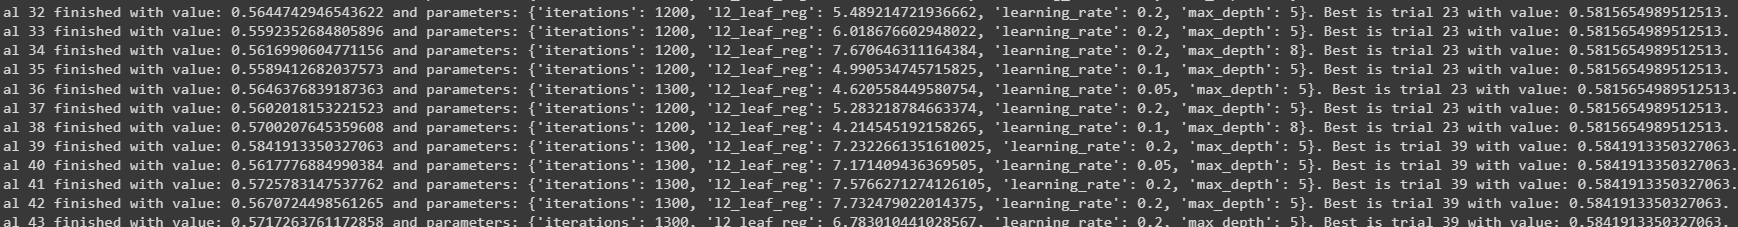

In [619]:
cat_clf = CatBoostClassifier(iterations=1300, l2_leaf_reg=7.2322661351610025, learning_rate = 0.2, max_depth=5,cat_features = cat_columns)

In [ ]:
cat_clf.fit(train_cat,train['interest_level'])

In [ ]:
{'iterations': 1300, 'l2_leaf_reg': 7.2322661351610025, 'learning_rate': 0.2, 'max_depth': 5}

In [624]:
test['interest_level']=cat_clf.predict(test.drop(['interest_level'],axis=1))
test[['listing_id', 'interest_level']].to_csv('sub_chernykh_cat_all_tuned.csv', index=None)

In [627]:
train_for_clf = train.drop(['interest_level'],axis=1)

In [636]:
cat_columns = []
num_columns = []

for column_name in train_for_clf.columns:
    if (train[column_name].dtypes == object):
        cat_columns +=[column_name]
    else:
        num_columns +=[column_name]

print('Категориальные данные:\t ',cat_columns, '\n Число столблцов = ',len(cat_columns))

print('Числовые данные:\t ',  num_columns, '\n Число столблцов = ',len(num_columns))

Категориальные данные:	  ['building_id', 'description', 'display_address', 'features', 'manager_id', 'photos', 'street_address'] 
 Число столблцов =  7
Числовые данные:	  ['bathrooms', 'bedrooms', 'created', 'latitude', 'listing_id', 'longitude', 'price', 'num_features', 'num_photos', 'distance_central_park', 'distance_time_square', 'distance_wall_street', 'pets_info', 'doorman_info', 'fitness_info', 'terrace_balcony', 'price_lower_than_2700', 'fee_inf', 'cool_manager', 'created_hour', 'created_month', 'price_label'] 
 Число столблцов =  22


In [645]:
num_columns = ['bathrooms',
 'bedrooms',
 'latitude',
 'listing_id',
 'longitude',
 'price',
 'num_features',
 'num_photos',
 'distance_central_park',
 'distance_time_square',
 'distance_wall_street',
 'pets_info',
 'doorman_info',
 'fitness_info',
 'terrace_balcony',
 'price_lower_than_2700',
 'fee_inf',
 'cool_manager',
 'created_hour',
 'created_month',
 'price_label']

In [ ]:
scaled_columns = scaler.fit_transform(train_for_clf[num_columns])

In [652]:
for i in range(len(scaled_features[0])):
  train_for_clf['scaled_columns' + '_' + str(i)] = train_for_clf.longitude

In [658]:
scaled_features

array([[-0.42344739, -1.37514216, -0.05899126, ..., -0.18486996,
         1.19138653,  0.43008996],
       [-0.42344739,  0.41254265, -0.01762031, ...,  0.05321886,
        -0.02097317,  1.27475899],
       [-0.42344739, -1.37514216,  0.01070828, ..., -0.89913642,
         1.19138653,  0.43008996],
       ...,
       [-0.42344739, -1.37514216, -0.20105493, ..., -0.42295878,
        -1.23333287,  0.43008996],
       [-0.42344739, -0.48129976,  0.03945759, ..., -0.42295878,
         1.19138653, -1.25924811],
       [-0.42344739, -1.37514216,  0.00818395, ..., -0.6610476 ,
         1.19138653,  0.43008996]])

In [661]:
for i in range(len(scaled_features[0])):
  print(i)
  for k in range(len(scaled_features)):
    train_for_clf['scaled_columns' + '_' + str(i)].iloc[k] = scaled_features[k][i]

0


C:\Users\user\AppData\Local\Temp\ipykernel_5440\2808516628.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_for_clf['scaled_columns' + '_' + str(i)].iloc[k] = scaled_features[k][i]


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [662]:
cat_clf = CatBoostClassifier(cat_features = cat_columns,random_state=SEED)

In [665]:
cat_clf.fit(train_for_clf,train[target])

Learning rate set to 0.095442
0:	learn: 1.0244880	total: 108ms	remaining: 1m 47s
1:	learn: 0.9670269	total: 223ms	remaining: 1m 51s
2:	learn: 0.9204972	total: 352ms	remaining: 1m 56s
3:	learn: 0.8834151	total: 490ms	remaining: 2m 1s
4:	learn: 0.8508074	total: 585ms	remaining: 1m 56s
5:	learn: 0.8231562	total: 707ms	remaining: 1m 57s
6:	learn: 0.8008044	total: 850ms	remaining: 2m
7:	learn: 0.7813102	total: 992ms	remaining: 2m 2s
8:	learn: 0.7637829	total: 1.11s	remaining: 2m 2s
9:	learn: 0.7465131	total: 1.25s	remaining: 2m 4s
10:	learn: 0.7311473	total: 1.39s	remaining: 2m 4s
11:	learn: 0.7186482	total: 1.47s	remaining: 2m 1s
12:	learn: 0.7067377	total: 1.59s	remaining: 2m 1s
13:	learn: 0.6967931	total: 1.68s	remaining: 1m 58s
14:	learn: 0.6875035	total: 1.81s	remaining: 1m 58s
15:	learn: 0.6794216	total: 1.93s	remaining: 1m 58s
16:	learn: 0.6721699	total: 2.07s	remaining: 1m 59s
17:	learn: 0.6656046	total: 2.21s	remaining: 2m
18:	learn: 0.6594617	total: 2.35s	remaining: 2m 1s
19:	lear

In [667]:
test = test.drop(['interest_level'],axis=1)

In [669]:
cat_columns = []
num_columns = []

for column_name in test.columns:
    if (train[column_name].dtypes == object):
        cat_columns +=[column_name]
    else:
        num_columns +=[column_name]

print('Категориальные данные:\t ',cat_columns, '\n Число столблцов = ',len(cat_columns))

print('Числовые данные:\t ',  num_columns, '\n Число столблцов = ',len(num_columns))

Категориальные данные:	  ['building_id', 'description', 'display_address', 'features', 'manager_id', 'photos', 'street_address'] 
 Число столблцов =  7
Числовые данные:	  ['bathrooms', 'bedrooms', 'created', 'latitude', 'listing_id', 'longitude', 'price', 'num_features', 'num_photos', 'distance_central_park', 'distance_time_square', 'distance_wall_street', 'fitness_info', 'terrace_balcony', 'pets_info', 'doorman_info', 'price_lower_than_2700', 'cool_manager', 'created_hour', 'created_month', 'price_label', 'fee_inf'] 
 Число столблцов =  22


In [678]:
num_columns = ['bathrooms',
 'bedrooms',
 'latitude',
 'listing_id',
 'longitude',
 'price',
 'num_features',
 'num_photos',
 'distance_central_park',
 'distance_time_square',
 'distance_wall_street',
 'pets_info',
 'doorman_info',
 'fitness_info',
 'terrace_balcony',
 'price_lower_than_2700',
 'fee_inf',
 'cool_manager',
 'created_hour',
 'created_month',
 'price_label']

In [679]:
scaled_features_test = scaler.fit_transform(test[num_columns])

In [680]:
for i in range(len(scaled_features_test[0])):
  test['scaled_columns' + '_' + str(i)] = test.longitude

In [681]:
for i in range(len(scaled_features_test[0])):
  print(i)
  for k in range(len(scaled_features_test)):
    test['scaled_columns' + '_' + str(i)].iloc[k] = scaled_features_test[k][i]

0


C:\Users\user\AppData\Local\Temp\ipykernel_5440\615114315.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['scaled_columns' + '_' + str(i)].iloc[k] = scaled_features_test[k][i]


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [685]:
test['interest_level']=cat_clf.predict(test)
test[['listing_id', 'interest_level']].to_csv('sub_chernykh_cat_scaled_features.csv', index=None)

In [686]:
cat_clf.feature_importances_

array([ 0.61162395,  4.47188881,  8.88027225,  2.48225672,  2.10190288,
        5.27619054,  5.77979199,  1.66131168,  1.99727258,  2.89430555,
       13.29172809,  0.        ,  9.66039236,  3.60430107,  1.77960721,
        1.86257659,  1.71552218,  2.49627523,  2.21913256,  0.40874662,
        0.17976118,  0.10639791,  0.07393456,  0.32904266,  1.32093125,
        0.10412829,  2.51436279,  0.10623403,  0.532732  ,  0.45005789,
        3.46746574,  0.76985175,  0.52955845,  1.25865355,  6.74309255,
        0.94651283,  0.64145298,  0.65601171,  1.28642034,  1.20878113,
        0.08955117,  0.11281396,  0.08118817,  0.11284964,  0.62642558,
        1.30715868,  0.07102516,  1.02806402,  0.03797883,  0.11246236])

In [687]:
dict(zip(train_for_clf,cat_clf.feature_importances_))

{'bathrooms': 0.611623949981249,
 'bedrooms': 4.47188880932376,
 'building_id': 8.880272250557553,
 'created': 2.482256715696004,
 'description': 2.1019028779698066,
 'display_address': 5.276190537443758,
 'features': 5.779791985151067,
 'latitude': 1.6613116828029015,
 'listing_id': 1.9972725805504363,
 'longitude': 2.894305551272107,
 'manager_id': 13.291728085094856,
 'photos': 0.0,
 'price': 9.660392355306735,
 'street_address': 3.6043010742791735,
 'num_features': 1.7796072071929112,
 'num_photos': 1.86257658602557,
 'distance_central_park': 1.7155221767774858,
 'distance_time_square': 2.4962752275606213,
 'distance_wall_street': 2.2191325625453366,
 'pets_info': 0.408746624621556,
 'doorman_info': 0.17976117860664553,
 'fitness_info': 0.10639791355453018,
 'terrace_balcony': 0.0739345593787913,
 'price_lower_than_2700': 0.32904265934556975,
 'fee_inf': 1.3209312510695068,
 'cool_manager': 0.10412829071355927,
 'created_hour': 2.5143627859879283,
 'created_month': 0.10623402524846

In [688]:
strong_features_exp = [key for key,value in dict(zip(train_for_clf,cat_clf.feature_importances_)).items() if value > 1.5]
strong_features_exp

['bedrooms',
 'building_id',
 'created',
 'description',
 'display_address',
 'features',
 'latitude',
 'listing_id',
 'longitude',
 'manager_id',
 'price',
 'street_address',
 'num_features',
 'num_photos',
 'distance_central_park',
 'distance_time_square',
 'distance_wall_street',
 'created_hour',
 'scaled_columns_1',
 'scaled_columns_5']

In [689]:
cat_columns = [
 'building_id',
 'description',
 'display_address',
 'features',
 'listing_id',
 'manager_id',
 'street_address']

In [690]:
cat_clf = CatBoostClassifier(cat_features = cat_columns,random_state=SEED)

In [691]:
cat_clf.fit(train_for_clf[strong_features_exp],train[target])

Learning rate set to 0.095442
0:	learn: 1.0237677	total: 106ms	remaining: 1m 45s
1:	learn: 0.9662106	total: 235ms	remaining: 1m 57s
2:	learn: 0.9192149	total: 381ms	remaining: 2m 6s
3:	learn: 0.8819936	total: 495ms	remaining: 2m 3s
4:	learn: 0.8498905	total: 596ms	remaining: 1m 58s
5:	learn: 0.8218982	total: 736ms	remaining: 2m 1s
6:	learn: 0.7988482	total: 839ms	remaining: 1m 58s
7:	learn: 0.7788877	total: 966ms	remaining: 1m 59s
8:	learn: 0.7598794	total: 1.1s	remaining: 2m 1s
9:	learn: 0.7434311	total: 1.19s	remaining: 1m 58s
10:	learn: 0.7289820	total: 1.29s	remaining: 1m 56s
11:	learn: 0.7170266	total: 1.38s	remaining: 1m 53s
12:	learn: 0.7069458	total: 1.48s	remaining: 1m 52s
13:	learn: 0.6974415	total: 1.61s	remaining: 1m 53s
14:	learn: 0.6888285	total: 1.74s	remaining: 1m 54s
15:	learn: 0.6816139	total: 1.84s	remaining: 1m 52s
16:	learn: 0.6735885	total: 1.96s	remaining: 1m 53s
17:	learn: 0.6677142	total: 2.05s	remaining: 1m 52s
18:	learn: 0.6622421	total: 2.14s	remaining: 1m 5

In [692]:
test['interest_level']=cat_clf.predict(test.drop(['interest_level'],axis = 1)[strong_features_exp])
test[['listing_id', 'interest_level']].to_csv('sub_chernykh_cat_scaled_features_strong.csv', index=None)

In [696]:
train_for_clf.columns

Index(['bathrooms', 'bedrooms', 'building_id', 'created', 'description',
       'display_address', 'features', 'latitude', 'listing_id', 'longitude',
       'manager_id', 'photos', 'price', 'street_address', 'num_features',
       'num_photos', 'distance_central_park', 'distance_time_square',
       'distance_wall_street', 'pets_info', 'doorman_info', 'fitness_info',
       'terrace_balcony', 'price_lower_than_2700', 'fee_inf', 'cool_manager',
       'created_hour', 'created_month', 'price_label', 'scaled_columns_0',
       'scaled_columns_1', 'scaled_columns_2', 'scaled_columns_3',
       'scaled_columns_4', 'scaled_columns_5', 'scaled_columns_6',
       'scaled_columns_7', 'scaled_columns_8', 'scaled_columns_9',
       'scaled_columns_10', 'scaled_columns_11', 'scaled_columns_12',
       'scaled_columns_13', 'scaled_columns_14', 'scaled_columns_15',
       'scaled_columns_16', 'scaled_columns_17', 'scaled_columns_18',
       'scaled_columns_19', 'scaled_columns_20'],
      dtype='obj

In [697]:
features_last = ['building_id',  'description',
       'display_address', 'features',  'listing_id', 
       'manager_id', 'photos',  'street_address',
       'scaled_columns_0',
       'scaled_columns_1', 'scaled_columns_2', 'scaled_columns_3',
       'scaled_columns_4', 'scaled_columns_5', 'scaled_columns_6',
       'scaled_columns_7', 'scaled_columns_8', 'scaled_columns_9',
       'scaled_columns_10', 'scaled_columns_11', 'scaled_columns_12',
       'scaled_columns_13', 'scaled_columns_14', 'scaled_columns_15',
       'scaled_columns_16', 'scaled_columns_17', 'scaled_columns_18',
       'scaled_columns_19', 'scaled_columns_20']

In [753]:
cat_columns = ['building_id',
 'description',
 'display_address',
 'features',
 'listing_id',
 'manager_id',
 'street_address',
 'photos']

In [705]:
cat_clf = CatBoostClassifier(cat_features = cat_columns, random_state=SEED)

In [706]:
cat_clf.fit(train_for_clf[features_last],train[target])

Learning rate set to 0.095442
0:	learn: 1.0252731	total: 151ms	remaining: 2m 30s
1:	learn: 0.9673778	total: 253ms	remaining: 2m 6s
2:	learn: 0.9208619	total: 369ms	remaining: 2m 2s
3:	learn: 0.8832410	total: 503ms	remaining: 2m 5s
4:	learn: 0.8512198	total: 642ms	remaining: 2m 7s
5:	learn: 0.8234457	total: 785ms	remaining: 2m 10s
6:	learn: 0.8003977	total: 944ms	remaining: 2m 13s
7:	learn: 0.7799354	total: 1.07s	remaining: 2m 12s
8:	learn: 0.7605132	total: 1.21s	remaining: 2m 13s
9:	learn: 0.7452751	total: 1.32s	remaining: 2m 10s
10:	learn: 0.7323844	total: 1.43s	remaining: 2m 8s
11:	learn: 0.7179442	total: 1.58s	remaining: 2m 10s
12:	learn: 0.7064071	total: 1.7s	remaining: 2m 8s
13:	learn: 0.6967686	total: 1.83s	remaining: 2m 8s
14:	learn: 0.6879155	total: 1.94s	remaining: 2m 7s
15:	learn: 0.6793705	total: 2.07s	remaining: 2m 7s
16:	learn: 0.6716719	total: 2.23s	remaining: 2m 8s
17:	learn: 0.6654768	total: 2.35s	remaining: 2m 8s
18:	learn: 0.6599591	total: 2.5s	remaining: 2m 8s
19:	le

In [707]:
test['interest_level']=cat_clf.predict(test.drop(['interest_level'],axis = 1)[features_last])
test[['listing_id', 'interest_level']].to_csv('sub_chernykh_cat_scaled_only.csv', index=None)

# АЛЯРМ ПОЛУЧЕН ТОП-1 СКОР

In [754]:
cat_clf = CatBoostClassifier(random_state=SEED, cat_features= cat_columns)

In [755]:
cat_clf.fit(train.drop(['interest_level'],axis = 1),train[target])

Learning rate set to 0.095442
0:	learn: 1.0252731	total: 126ms	remaining: 2m 5s
1:	learn: 0.9673778	total: 238ms	remaining: 1m 58s
2:	learn: 0.9208619	total: 365ms	remaining: 2m 1s
3:	learn: 0.8832410	total: 490ms	remaining: 2m 1s
4:	learn: 0.8516667	total: 601ms	remaining: 1m 59s
5:	learn: 0.8240862	total: 732ms	remaining: 2m 1s
6:	learn: 0.8005639	total: 932ms	remaining: 2m 12s
7:	learn: 0.7800793	total: 1.08s	remaining: 2m 14s
8:	learn: 0.7606645	total: 1.23s	remaining: 2m 15s
9:	learn: 0.7454097	total: 1.36s	remaining: 2m 14s
10:	learn: 0.7324376	total: 1.5s	remaining: 2m 14s
11:	learn: 0.7180011	total: 1.68s	remaining: 2m 18s
12:	learn: 0.7064281	total: 1.82s	remaining: 2m 18s
13:	learn: 0.6967592	total: 1.96s	remaining: 2m 18s
14:	learn: 0.6879087	total: 2.08s	remaining: 2m 16s
15:	learn: 0.6791113	total: 2.24s	remaining: 2m 17s
16:	learn: 0.6718777	total: 2.4s	remaining: 2m 18s
17:	learn: 0.6656650	total: 2.51s	remaining: 2m 17s
18:	learn: 0.6601745	total: 2.68s	remaining: 2m 18

In [756]:
dict(zip(train.drop(['interest_level'],axis = 1),cat_clf.feature_importances_))

{'bathrooms': 1.1892658482008995,
 'bedrooms': 7.70223130885555,
 'building_id': 9.470725045544846,
 'created': 4.354472199859794,
 'description': 2.0126901934135293,
 'display_address': 5.6258154204407536,
 'features': 5.735339405401724,
 'latitude': 2.195903537736855,
 'listing_id': 0.0,
 'longitude': 4.2255990441839595,
 'manager_id': 13.57750898024376,
 'photos': 0.27390963833494597,
 'price': 16.7561953036491,
 'street_address': 3.3655242204849865,
 'num_features': 2.4717247114499945,
 'num_photos': 2.5804916133756124,
 'distance_central_park': 2.7032870315659636,
 'distance_time_square': 3.650119308405602,
 'distance_wall_street': 3.8726907532907084,
 'pets_info': 0.45717603659865047,
 'doorman_info': 0.2713156326431368,
 'fitness_info': 0.2041700191815334,
 'terrace_balcony': 0.13155982972428432,
 'price_lower_than_2700': 0.7113345118934684,
 'fee_inf': 2.5328549839633765,
 'cool_manager': 0.09671335829042806,
 'created_hour': 3.0285704612889663,
 'created_month': 0.057783573746

In [758]:
strong_features_exp_2 = [key for key,value in dict(zip(train.drop(['interest_level'],axis = 1),cat_clf.feature_importances_)).items() if value > 2]
strong_features_exp_2

['bedrooms',
 'building_id',
 'created',
 'description',
 'display_address',
 'features',
 'latitude',
 'longitude',
 'manager_id',
 'price',
 'street_address',
 'num_features',
 'num_photos',
 'distance_central_park',
 'distance_time_square',
 'distance_wall_street',
 'fee_inf',
 'created_hour']

In [751]:
cat_columns = ['building_id',
 'description',
 'display_address',
 'features',
 'manager_id']

In [749]:
cat_clf = CatBoostClassifier(random_state=SEED, cat_features=cat_columns)

In [722]:
cat_clf.fit(train_for_clf[strong_features_exp_2],train[target])

Learning rate set to 0.095442
0:	learn: 1.0251804	total: 113ms	remaining: 1m 52s
1:	learn: 0.9675796	total: 222ms	remaining: 1m 50s
2:	learn: 0.9203926	total: 297ms	remaining: 1m 38s
3:	learn: 0.8816745	total: 383ms	remaining: 1m 35s
4:	learn: 0.8492950	total: 504ms	remaining: 1m 40s
5:	learn: 0.8224067	total: 616ms	remaining: 1m 42s
6:	learn: 0.7989665	total: 744ms	remaining: 1m 45s
7:	learn: 0.7782987	total: 840ms	remaining: 1m 44s
8:	learn: 0.7599451	total: 937ms	remaining: 1m 43s
9:	learn: 0.7456494	total: 1.04s	remaining: 1m 43s
10:	learn: 0.7298708	total: 1.17s	remaining: 1m 45s
11:	learn: 0.7161677	total: 1.28s	remaining: 1m 45s
12:	learn: 0.7043672	total: 1.36s	remaining: 1m 43s
13:	learn: 0.6946000	total: 1.47s	remaining: 1m 43s
14:	learn: 0.6851521	total: 1.57s	remaining: 1m 43s
15:	learn: 0.6767767	total: 1.68s	remaining: 1m 43s
16:	learn: 0.6697178	total: 1.81s	remaining: 1m 44s
17:	learn: 0.6635024	total: 1.91s	remaining: 1m 44s
18:	learn: 0.6577931	total: 2.03s	remaining:

In [723]:
test['interest_level']=cat_clf.predict(test.drop(['interest_level'],axis = 1)[strong_features_exp_2])
test[['listing_id', 'interest_level']].to_csv('sub_chernykh_cat_scaled_features_strong_2.csv', index=None)

ПРУФ  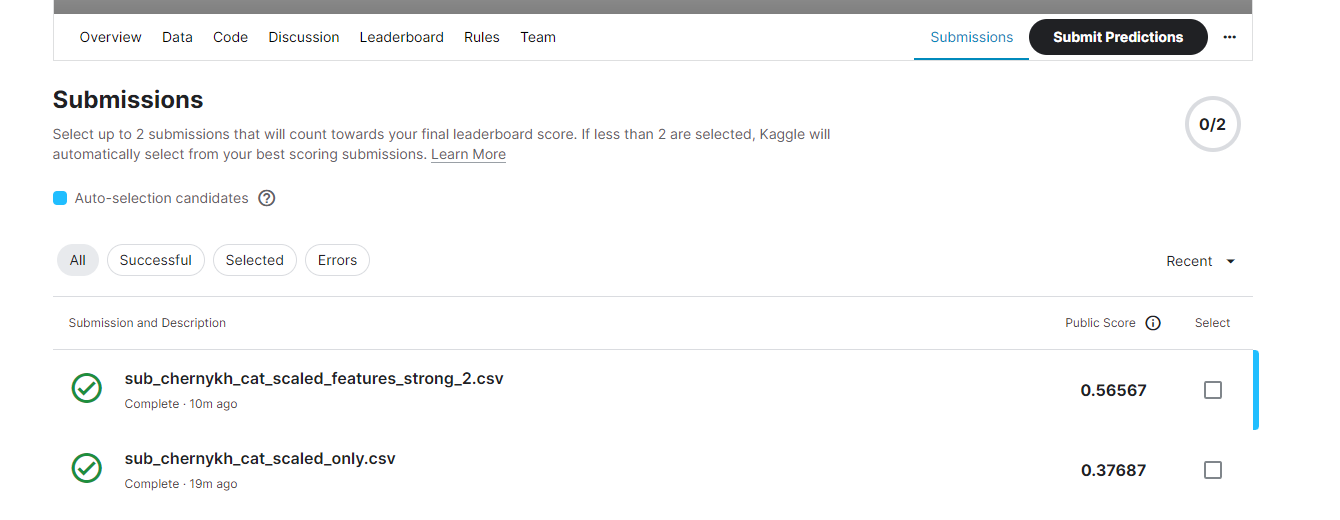

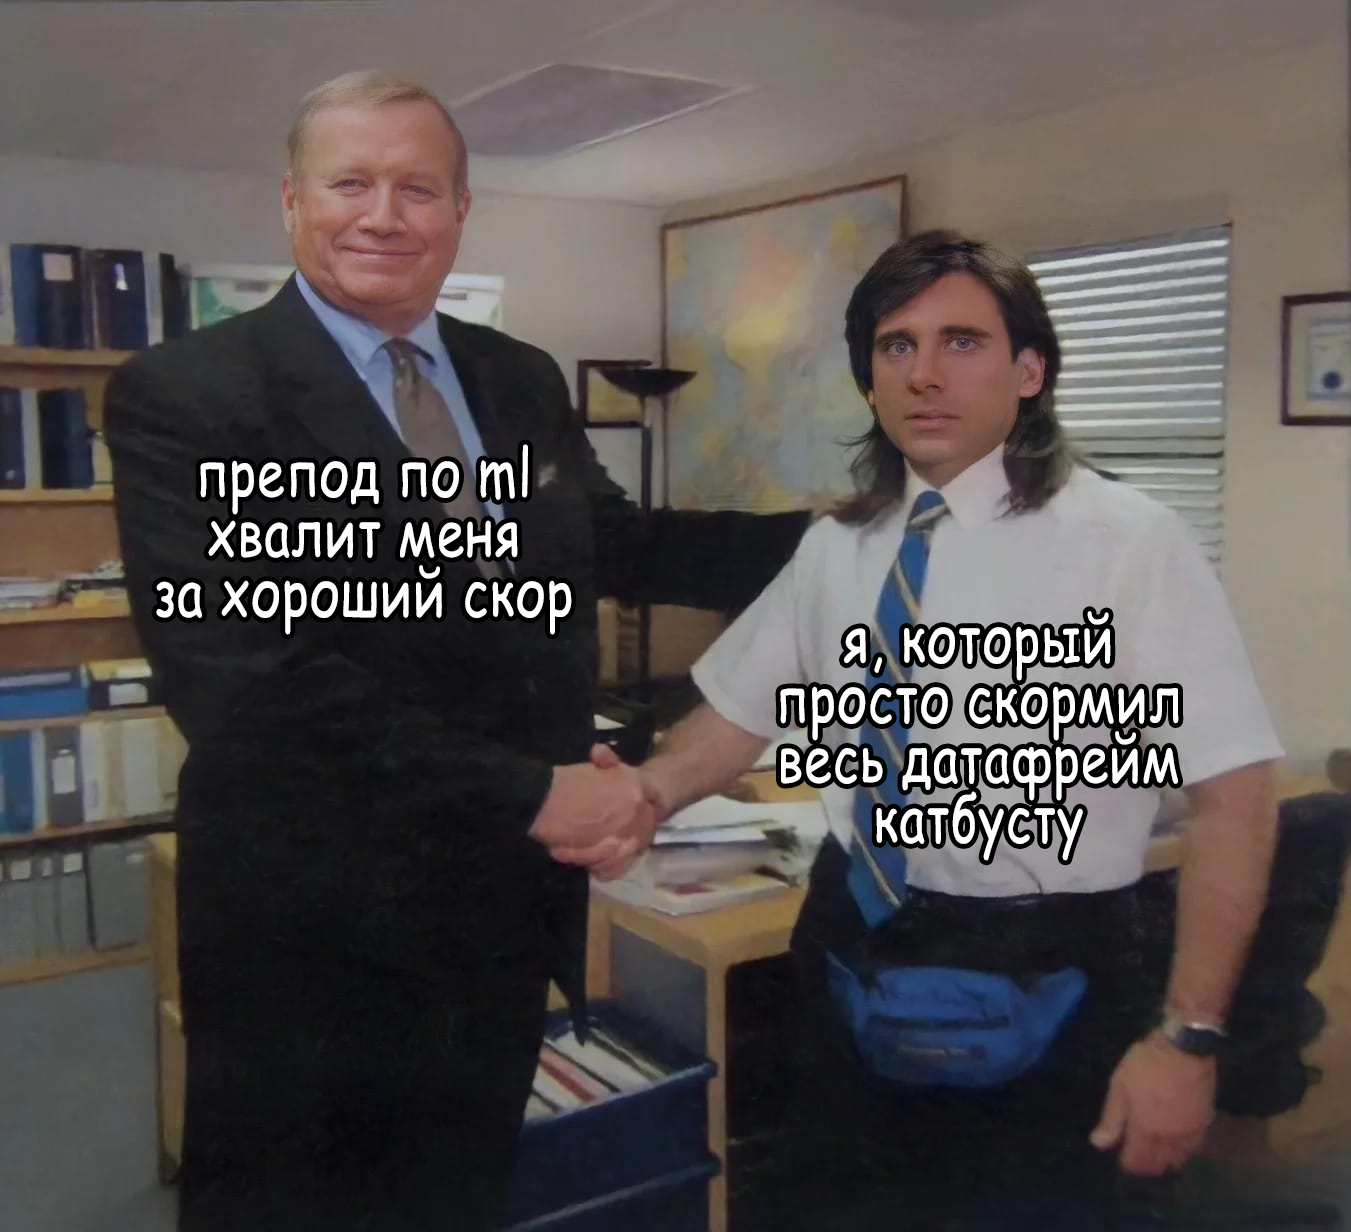

In [759]:
cat_columns = ['bedrooms',
 'building_id',
 'description',
 'display_address',
 'features',
 'manager_id',
 'street_address',]

In [760]:
X = train_for_clf[strong_features_exp_2]
y = train['interest_level']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=SEED)

In [761]:
def objective_cat(trial):   
    param = {
        'iterations': trial.suggest_categorical('iterations', [500, 800, 1000, 1100]), 
        'verbose': 0, #
        'random_seed': SEED,
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 5, 8),
        'classes_count': 3,
        'early_stopping_rounds' : 10,
        'cat_features': cat_columns,
        'learning_rate': trial.suggest_categorical('learning_rate', [0.05, 0.1, 0.15, 0.2]),
        'max_depth': trial.suggest_categorical('max_depth', [5, 6, 7, 8])
    }
    model = CatBoostClassifier(**param)  
    
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    
    f1 = f1_score(y_test, preds, average='macro')
    
    return f1

In [762]:
study_cat = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=SEED))
study_cat.optimize(objective_cat, n_trials=100)

[I 2022-12-14 11:39:20,237] A new study created in memory with name: no-name-afbc806c-f31d-48a6-99aa-40a2a1dc6a4f
[I 2022-12-14 11:41:47,963] Trial 0 finished with value: 0.5635022468440388 and parameters: {'iterations': 800, 'l2_leaf_reg': 7.854373872339018, 'learning_rate': 0.1, 'max_depth': 7}. Best is trial 0 with value: 0.5635022468440388.
[I 2022-12-14 11:46:00,846] Trial 1 finished with value: 0.5461881316425877 and parameters: {'iterations': 1000, 'l2_leaf_reg': 5.338572960895124, 'learning_rate': 0.2, 'max_depth': 8}. Best is trial 0 with value: 0.5635022468440388.
[I 2022-12-14 11:50:20,844] Trial 2 finished with value: 0.5506729263671306 and parameters: {'iterations': 1000, 'l2_leaf_reg': 7.666697941328927, 'learning_rate': 0.1, 'max_depth': 8}. Best is trial 0 with value: 0.5635022468440388.
[I 2022-12-14 11:52:08,487] Trial 3 finished with value: 0.5619778671498906 and parameters: {'iterations': 1000, 'l2_leaf_reg': 7.485395399757388, 'learning_rate': 0.2, 'max_depth': 5}.

In [763]:
print('Параметры, полученные при лучшей оценке:', study_cat.best_trial.params)

Параметры, полученные при лучшей оценке: {'iterations': 1000, 'l2_leaf_reg': 6.874189542993058, 'learning_rate': 0.2, 'max_depth': 7}


In [781]:
cat_clf = CatBoostClassifier(iterations=1100,l2_leaf_reg= 6,learning_rate = 0.1, max_depth= 5,random_state=SEED, cat_features=cat_columns, boosting_type='Plain',) #загрузить топ параметрыиз обучения выше

In [782]:
cat_clf.fit(train_for_clf[strong_features_exp_2],train[target])

0:	learn: 1.0240375	total: 145ms	remaining: 2m 39s
1:	learn: 0.9671278	total: 239ms	remaining: 2m 11s
2:	learn: 0.9206997	total: 361ms	remaining: 2m 11s
3:	learn: 0.8813063	total: 461ms	remaining: 2m 6s
4:	learn: 0.8489598	total: 605ms	remaining: 2m 12s
5:	learn: 0.8228348	total: 729ms	remaining: 2m 12s
6:	learn: 0.8000892	total: 893ms	remaining: 2m 19s
7:	learn: 0.7810098	total: 1.03s	remaining: 2m 20s
8:	learn: 0.7639306	total: 1.18s	remaining: 2m 22s
9:	learn: 0.7486428	total: 1.28s	remaining: 2m 19s
10:	learn: 0.7337452	total: 1.36s	remaining: 2m 14s
11:	learn: 0.7213232	total: 1.45s	remaining: 2m 11s
12:	learn: 0.7097514	total: 1.55s	remaining: 2m 9s
13:	learn: 0.6996773	total: 1.64s	remaining: 2m 7s
14:	learn: 0.6919504	total: 1.73s	remaining: 2m 4s
15:	learn: 0.6838514	total: 1.81s	remaining: 2m 2s
16:	learn: 0.6770153	total: 1.91s	remaining: 2m 1s
17:	learn: 0.6706928	total: 1.98s	remaining: 1m 59s
18:	learn: 0.6655782	total: 2.08s	remaining: 1m 58s
19:	learn: 0.6609348	total: 

In [783]:
test['interest_level']=cat_clf.predict(test.drop(['interest_level'],axis = 1)[strong_features_exp_2])
test[['listing_id', 'interest_level']].to_csv('sub_chernykh_cat_top_score_tuned_2.csv', index=None) #0.55

Лемматизация текста

In [ ]:
import nltk

nltk.download('all')
import numpy as np
import pandas as pd
from tqdm import tqdm

import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer  
stop_words = stopwords.words('english')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report

import matplotlib.pyplot as plt
import seaborn as sns

In [785]:
sw = stopwords.words('english')
lemmatizer = WordNetLemmatizer() 

def clean_text(text):
    
    text = text.lower()
    
    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text) # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")

    text = re.sub(r"http\S+", "",text) #Removing URLs 
    #text = re.sub(r"http", "",text)
    
    html=re.compile(r'<.*?>') 
    
    text = html.sub(r'',text) #Removing html tags
    
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'
    for p in punctuations:
        text = text.replace(p,'') #Removing punctuations
        
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    
    text = [lemmatizer.lemmatize(word) for word in text]
    
    text = " ".join(text) #removing stopwords
    
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text) #Removing emojis
    
    return text


In [786]:
train['lematazed_desc'] = train.description.apply(lambda x: clean_text(str(x)))

In [787]:
cat_columns = []
num_columns = []

for column_name in train.columns:
    if (train[column_name].dtypes == object):
        cat_columns +=[column_name]
    else:
        num_columns +=[column_name]

print('Категориальные данные:\t ',cat_columns, '\n Число столблцов = ',len(cat_columns))

print('Числовые данные:\t ',  num_columns, '\n Число столблцов = ',len(num_columns))

Категориальные данные:	  ['building_id', 'description', 'display_address', 'features', 'manager_id', 'photos', 'street_address', 'lematazed_desc'] 
 Число столблцов =  8
Числовые данные:	  ['bathrooms', 'bedrooms', 'created', 'latitude', 'listing_id', 'longitude', 'price', 'interest_level', 'num_features', 'num_photos', 'distance_central_park', 'distance_time_square', 'distance_wall_street', 'pets_info', 'doorman_info', 'fitness_info', 'terrace_balcony', 'price_lower_than_2700', 'fee_inf', 'cool_manager', 'created_hour', 'created_month', 'price_label'] 
 Число столблцов =  23


In [793]:
train.columns

Index(['bathrooms', 'bedrooms', 'building_id', 'created', 'description',
       'display_address', 'features', 'latitude', 'listing_id', 'longitude',
       'manager_id', 'photos', 'price', 'street_address', 'interest_level',
       'num_features', 'num_photos', 'distance_central_park',
       'distance_time_square', 'distance_wall_street', 'pets_info',
       'doorman_info', 'fitness_info', 'terrace_balcony',
       'price_lower_than_2700', 'fee_inf', 'cool_manager', 'created_hour',
       'created_month', 'price_label', 'lematazed_desc'],
      dtype='object')

In [788]:
cat_clf = CatBoostClassifier(random_state=SEED, cat_features= cat_columns)

In [789]:
cat_clf.fit(train.drop(['interest_level'],axis = 1),train[target])

Learning rate set to 0.095442
0:	learn: 1.0248770	total: 132ms	remaining: 2m 11s
1:	learn: 0.9690185	total: 272ms	remaining: 2m 15s
2:	learn: 0.9214240	total: 409ms	remaining: 2m 15s
3:	learn: 0.8837288	total: 546ms	remaining: 2m 16s
4:	learn: 0.8518429	total: 645ms	remaining: 2m 8s
5:	learn: 0.8247107	total: 788ms	remaining: 2m 10s
6:	learn: 0.8014733	total: 905ms	remaining: 2m 8s
7:	learn: 0.7819798	total: 1.04s	remaining: 2m 8s
8:	learn: 0.7630412	total: 1.16s	remaining: 2m 7s
9:	learn: 0.7461172	total: 1.29s	remaining: 2m 7s
10:	learn: 0.7312866	total: 1.41s	remaining: 2m 6s
11:	learn: 0.7181183	total: 1.54s	remaining: 2m 7s
12:	learn: 0.7071278	total: 1.67s	remaining: 2m 7s
13:	learn: 0.6971987	total: 1.8s	remaining: 2m 7s
14:	learn: 0.6878980	total: 1.94s	remaining: 2m 7s
15:	learn: 0.6800776	total: 2.06s	remaining: 2m 6s
16:	learn: 0.6729437	total: 2.19s	remaining: 2m 6s
17:	learn: 0.6660228	total: 2.34s	remaining: 2m 7s
18:	learn: 0.6592653	total: 2.48s	remaining: 2m 8s
19:	lea

In [795]:
dict(zip(train.drop(['interest_level'],axis = 1), cat_clf.feature_importances_ ))

{'bathrooms': 1.0670075678031503,
 'bedrooms': 7.939571488079681,
 'building_id': 9.268332389134365,
 'created': 2.561611991745567,
 'description': 0.0,
 'display_address': 5.714817659348692,
 'features': 5.8002869381864794,
 'latitude': 2.2109530616651214,
 'listing_id': 2.607387501815537,
 'longitude': 4.451569536783076,
 'manager_id': 13.102842273844496,
 'photos': 0.0,
 'price': 16.954118538672024,
 'street_address': 2.64185824109146,
 'num_features': 2.7323589661044814,
 'num_photos': 2.805971389324769,
 'distance_central_park': 2.76496155158484,
 'distance_time_square': 3.543657583607838,
 'distance_wall_street': 3.620701245395447,
 'pets_info': 0.4983035260119951,
 'doorman_info': 0.3271154188035796,
 'fitness_info': 0.1796903629867733,
 'terrace_balcony': 0.16795518286389483,
 'price_lower_than_2700': 0.6493527468814175,
 'fee_inf': 2.3970271522996485,
 'cool_manager': 0.23730826308373268,
 'created_hour': 2.9864300363153777,
 'created_month': 0.1252142936086846,
 'price_label'

In [796]:
strong_features_exp_final = [key for key,value in dict(zip(train.drop(['interest_level'],axis = 1),cat_clf.feature_importances_)).items() if value > 2]
strong_features_exp_final

['bedrooms',
 'building_id',
 'created',
 'display_address',
 'features',
 'latitude',
 'listing_id',
 'longitude',
 'manager_id',
 'price',
 'street_address',
 'num_features',
 'num_photos',
 'distance_central_park',
 'distance_time_square',
 'distance_wall_street',
 'fee_inf',
 'created_hour',
 'lematazed_desc']

In [803]:
cat_columns = [
 'building_id',
 'display_address',
 'features',
 'listing_id',
 'manager_id',
 'street_address',
 'lematazed_desc']

In [808]:
cat_clf = CatBoostClassifier(iterations=1100 ,random_state=SEED, cat_features=cat_columns,max_depth=7)

In [809]:
cat_clf.fit(train[strong_features_exp_final],train[target])

Learning rate set to 0.088057
0:	learn: 1.0297882	total: 135ms	remaining: 2m 27s
1:	learn: 0.9750783	total: 272ms	remaining: 2m 29s
2:	learn: 0.9298493	total: 423ms	remaining: 2m 34s
3:	learn: 0.8920840	total: 575ms	remaining: 2m 37s
4:	learn: 0.8604567	total: 700ms	remaining: 2m 33s
5:	learn: 0.8340128	total: 858ms	remaining: 2m 36s
6:	learn: 0.8099011	total: 996ms	remaining: 2m 35s
7:	learn: 0.7912393	total: 1.11s	remaining: 2m 31s
8:	learn: 0.7742256	total: 1.25s	remaining: 2m 32s
9:	learn: 0.7582233	total: 1.4s	remaining: 2m 32s
10:	learn: 0.7432719	total: 1.57s	remaining: 2m 35s
11:	learn: 0.7290688	total: 1.72s	remaining: 2m 36s
12:	learn: 0.7155695	total: 1.91s	remaining: 2m 39s
13:	learn: 0.7044983	total: 2.08s	remaining: 2m 41s
14:	learn: 0.6939920	total: 2.25s	remaining: 2m 42s
15:	learn: 0.6853087	total: 2.39s	remaining: 2m 42s
16:	learn: 0.6771598	total: 2.56s	remaining: 2m 42s
17:	learn: 0.6698693	total: 2.72s	remaining: 2m 43s
18:	learn: 0.6635739	total: 2.88s	remaining: 

In [806]:
test['lematazed_desc'] = test.description.apply(lambda x: clean_text(str(x)))

In [810]:
test['interest_level']=cat_clf.predict(test.drop(['interest_level'],axis = 1)[strong_features_exp_final])
test[['listing_id', 'interest_level']].to_csv('sub_chernykh_cat_exp_final_2.csv', index=None)